# **Inventory and Merge Runs of well log LAS data stored as seperate files**
---
---
# Use the files in the **"_rename"** folder:

In [1]:

import warnings
warnings.filterwarnings("ignore")

import os, glob, re

import lasio
from lasio import CurveItem

import pandas as pd
import panel as pn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import for manually creating colored legend labels


# Initialize Panel
pn.extension()

import base64
from io import BytesIO
#from IPython.core.display import display, HTML
from IPython.display import display, HTML

pn.extension(sizing_mode="stretch_width")

SUFFIXES = ( "_renamed")

# --- helpers ---
def find_renamed_folders():
    # looks in CURRENT working directory
    folders = []
    for name in sorted(os.listdir(".")):
        if os.path.isdir(name) and name.endswith(SUFFIXES):
            folders.append(name)
    return folders

def list_las_files(folder, pattern="*.las"):
    return sorted(glob.glob(os.path.join(folder, pattern)))

# --- widgets ---
refresh = pn.widgets.Button(name="Refresh", button_type="primary")
folder_select = pn.widgets.Select(name="Select renamed folder", options=[])
pattern = pn.widgets.TextInput(name="File pattern", value="*.las")

# --- output panes ---
cwd_md    = pn.pane.Markdown("")
status_md = pn.pane.Markdown("")
files_md  = pn.pane.Markdown("", sizing_mode="stretch_both")

# --- globals this cell will define for downstream notebook cells ---
file_directory = None   # selected folder name
active_dir = None       # same as selected folder path (./<folder>)
las_files = []          # list of LAS files in active_dir

def sync_state_and_render():
    """Update folder list, set globals (file_directory/active_dir/las_files), render output."""
    global file_directory, active_dir, las_files

    # Always show where we are scanning
    cwd_md.object = f"**Current working directory:** `{os.getcwd()}`"

    # Update dropdown options
    folders = find_renamed_folders()
    folder_select.options = folders

    # Preserve selection if possible
    if folders:
        if folder_select.value not in folders:
            folder_select.value = folders[0]
    else:
        folder_select.value = None

    # If nothing to select, clear state
    if not folder_select.value:
        file_directory = None
        active_dir = None
        las_files = []
        status_md.object = "⚠️ No folders ending in `_rename` or `_renamed` found in the current working directory."
        files_md.object = ""
        return

    # Set "working folder" state
    file_directory = folder_select.value
    active_dir = os.path.join(".", file_directory)
    las_files = list_las_files(active_dir, pattern.value.strip() or "*.las")

    # Render
    status_md.object = (
        f"### Working folder set\n"
        f"**file_directory:** `{file_directory}`  \n"
        f"**active_dir:** `{os.path.abspath(active_dir)}`  \n\n"
        f"**LAS files found:** {len(las_files)}"
    )
    files_md.object = "❌ No matching files." if not las_files else "\n".join([f"- `{f}`" for f in las_files])

def on_refresh(event=None):
    sync_state_and_render()

# Reactive updates
refresh.on_click(on_refresh)
folder_select.param.watch(lambda e: sync_state_and_render(), "value")
pattern.param.watch(lambda e: sync_state_and_render(), "value")

# Initial run
sync_state_and_render()

pn.Column(
    "## Select renamed folder (sets `file_directory`, `active_dir`, `las_files`)",
    pn.Row(folder_select, pattern, refresh),
    pn.pane.Markdown("---"),
    cwd_md,
    status_md,
    files_md,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Select(options=['BRAAFLAT 11-11H-old_rena...], sizing_mode='stretch_width', value='BRAAFLAT 11-11H-old_renam...)
        [1] TextInput(name='File pattern', sizing_mode='stretch_width', value='*.las')
        [2] Button(button_type='primary', name='Refresh', sizing_mode='stretch_width')
    [2] Markdown(str, sizing_mode='stretch_width')
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Markdown(str, sizing_mode='stretch_width')
    [5] Markdown(str, sizing_mode='stretch_both')

---
# Plot Presence of all available log curve data colored by las file

## First create an Andy McDonald type of depth plot that highlights the depths that have data for each log curve for each run colored by las file:

Andy has some great tutorials available on GitHub, LinkedIn and Medium. 

Plot saved as Depth_plot_Andy_Deadwood_Canyon_Ranch_43-28H_Bakken_renamed_colored_by_las_file.png_colored_by_las_file


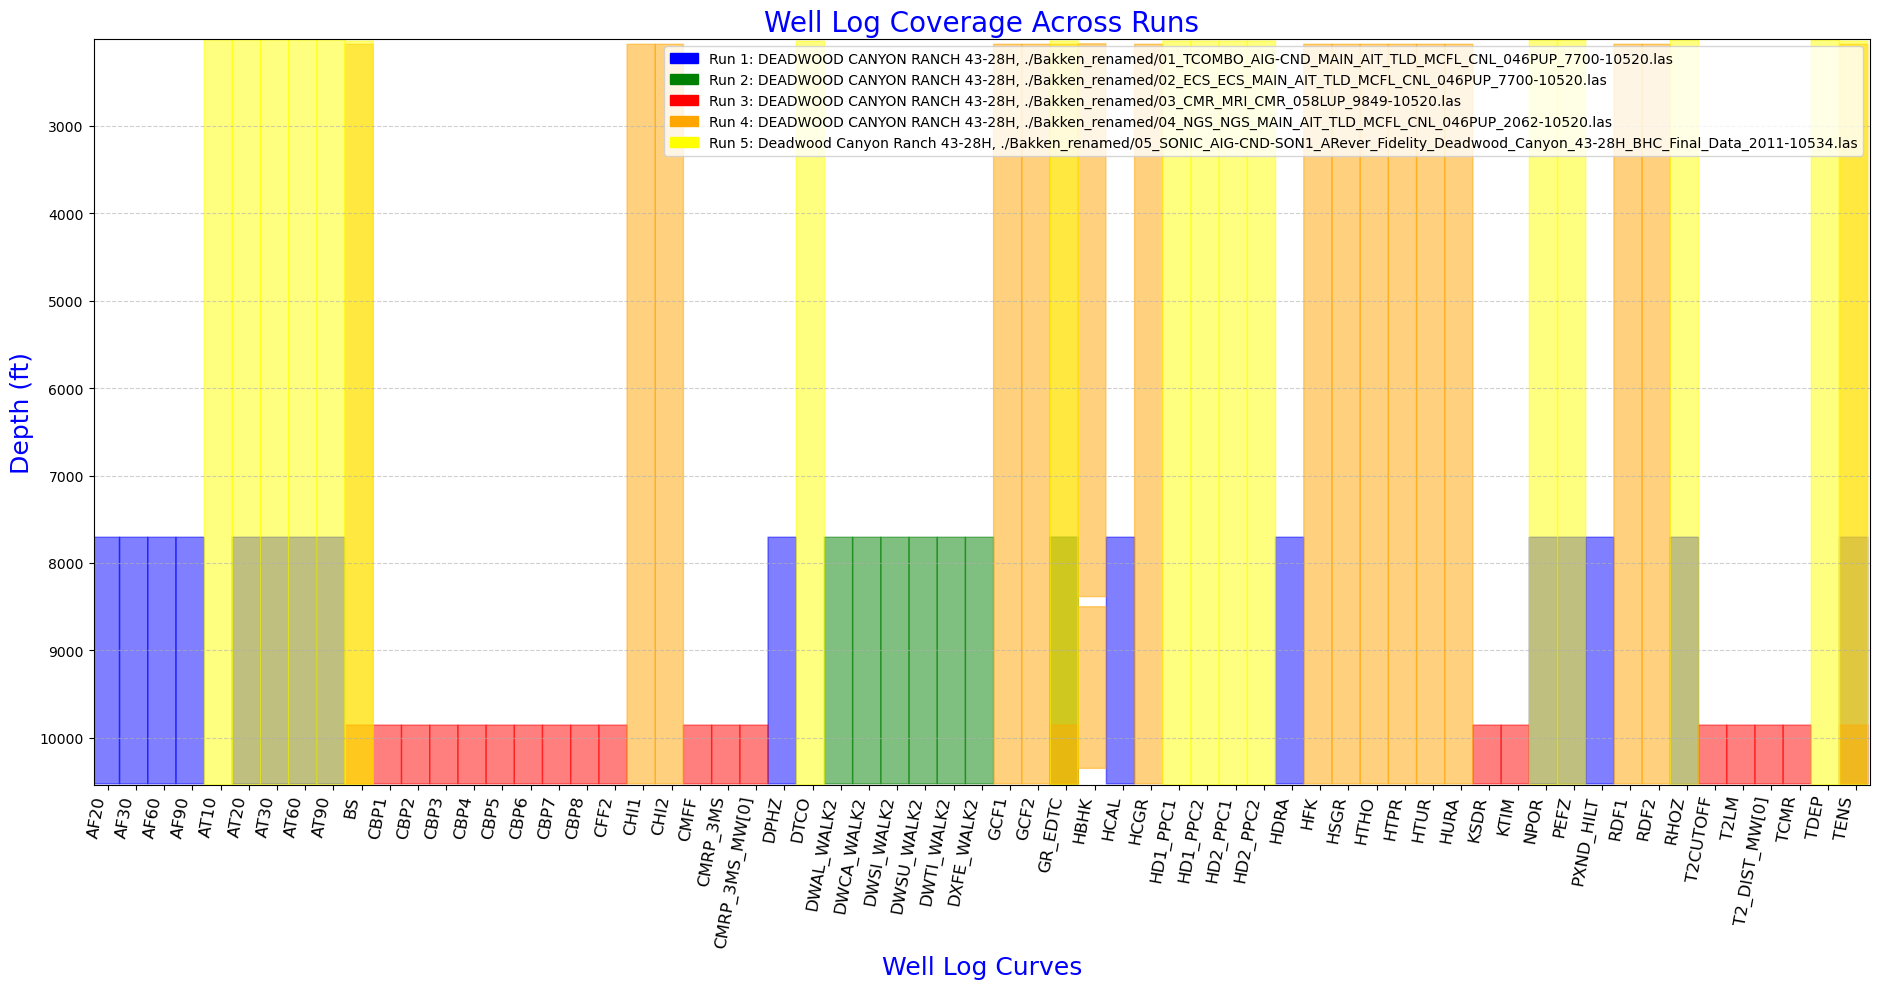

In [2]:
# Function to read LAS file and extract depth and log availability
def get_well_nan(file):
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]
    well_nan = df_log.notnull().astype(int)  # Convert to binary (1=Available, 0=Missing)
    wellname = las.well.WELL.value if "WELL" in las.well else file  # Get well name
    return wellname, df_log.index, well_nan

# Read all LAS files and store data
las_data = [get_well_nan(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]
alpha = 0.5  # Transparency for shading

# Create figure with tracks for all unique curves
fig, ax = plt.subplots(figsize=(len(all_available_curves) * 0.3, 10))  # Increase width for better label spacing

# Well name storage for legend (with correct colors)
legend_patches = []

# Loop through each LAS file and shade where logs are present
for run_index, (wellname, depth, well_nan) in enumerate(las_data):
    legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}, {las_files[run_index]}"))    
    #legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}"))
    for j, curve in enumerate(all_available_curves):
        if curve in well_nan.columns:
            ax.fill_betweenx(depth, j - 0.6, j + 0.4, where=well_nan[curve] == 1, 
                             color=run_colors[run_index], alpha=alpha)

# Format plot
ax.set_xlim(-0.5, len(all_available_curves) - 0.5)  # Keep x-axis aligned
ax.set_ylim(max_depth, min_depth)  # Ensure depth increases downward
ax.set_xticks(range(len(all_available_curves)))
ax.set_xticklabels(all_available_curves, rotation=80, fontsize=12, ha="right")  # Rotate & align right
ax.set_xlabel("Well Log Curves", fontsize=18, color = 'blue')
ax.set_ylabel("Depth (ft)", fontsize=18, color = 'blue')
ax.set_title("Well Log Coverage Across Runs", fontsize=20, color='blue')
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add well names to legend (ensuring correct colors)
ax.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.subplots_adjust(bottom=0.25)  # Extra space for x-axis labels
plt.tight_layout()

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name


# **Save the image**
'''image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"'''
image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}_colored_by_las_file")

plt.show()



---
---
# **Total Curve Inventory for each LAS File**

## Typical report for all meta data for each las files:

Very simple display of well log header data in las file. 

In [3]:
import os
import numpy as np
import pandas as pd
import lasio
import panel as pn

pn.extension("tabulator", sizing_mode="stretch_width")

# ---- Requires las_files from your folder-picker cell ----
if "las_files" not in globals() or not las_files:
    raise ValueError("`las_files` is empty. Run your folder-selection cell first.")

# ---- Simple cache so switching files is fast ----
_LAS_CACHE = {}
def read_las_cached(path):
    if path not in _LAS_CACHE:
        _LAS_CACHE[path] = lasio.read(path)
    return _LAS_CACHE[path]

# ---- UI widgets ----
file_names = [os.path.basename(p) for p in las_files]
file_map = dict(zip(file_names, las_files))

file_selector = pn.widgets.Select(name="LAS file", options=file_names, width=800)

prev_btn = pn.widgets.Button(name="◀ Prev", button_type="default")
next_btn = pn.widgets.Button(name="Next ▶", button_type="default")

sample_curve_choices = pn.widgets.MultiChoice(
    name="Sample curves (shown in table)",
    options=["DEPT","GR","RHOZ","RHOB","TNPH","NPOR","RT","RS","TCMR","CMRP_3MS","BFV","DCAL","CALI","BS","DRHO"],
    value=["DEPT","GR","RHOZ","TNPH"]
)

nrows = pn.widgets.IntInput(name="Sample rows", value=5, start=1, end=50)

# ---- Output panes ----
header_md = pn.pane.Markdown("")
curves_tbl = pn.widgets.Tabulator(pd.DataFrame(), height=260, pagination="local", page_size=12)
well_tbl   = pn.widgets.Tabulator(pd.DataFrame(), height=260, pagination="local", page_size=12)
depth_tbl  = pn.widgets.Tabulator(pd.DataFrame(), height=140)
sample_tbl = pn.widgets.Tabulator(pd.DataFrame(), height=220)

def build_review(file_key, curve_list, nrows_):
    if not file_key:
        return

    path = file_map[file_key]
    las = read_las_cached(path)

    # --- Header / version ---
    las_version = ""
    try:
        if las.version:
            # las.version is a Section; keep it short
            las_version = ", ".join([f"{k}:{v.value}" for k, v in las.version.items() if hasattr(v, "value")])
    except Exception:
        las_version = ""

    header_md.object = (
        f"## Reviewing `{file_key}`\n"
        f"**Path:** `{path}`  \n"
        f"**LAS Version:** `{las_version or 'N/A'}`"
    )

    # --- Well section ---
    well_info = {}
    if getattr(las, "well", None):
        for k, v in las.well.items():
            try:
                unit = (v.unit or "").strip()
                val = v.value
                well_info[str(k)] = f"{val} {unit}".strip() if unit else val
            except Exception:
                well_info[str(k)] = str(v)

    well_df = pd.DataFrame(
        [{"Mnemonic": k, "Value": v} for k, v in well_info.items()]
    )

    # --- Curves section ---
    curve_df = pd.DataFrame(
        [{"Mnemonic": c.mnemonic, "Unit": c.unit, "Description": c.descr} for c in las.curves]
    )

    # --- Depth range ---
    if "DEPT" in las.keys():
        d = np.asarray(las["DEPT"], float)
        d = d[np.isfinite(d)]
        if d.size:
            depth_df = pd.DataFrame([{"Top (min)": float(np.min(d)), "Base (max)": float(np.max(d))}])
        else:
            depth_df = pd.DataFrame([{"Error": "DEPT exists but contains no finite values"}])
    else:
        depth_df = pd.DataFrame([{"Error": "Depth curve ('DEPT') not found"}])

    # --- Sample data table ---
    chosen = [c for c in curve_list if c in las.keys()]
    if "DEPT" in las.keys() and "DEPT" not in chosen:
        chosen = ["DEPT"] + chosen

    if chosen:
        # Build from LAS curves directly
        sample = {}
        for c in chosen:
            try:
                sample[c] = np.asarray(las[c])[: int(nrows_)]
            except Exception:
                sample[c] = [np.nan] * int(nrows_)
        sample_df = pd.DataFrame(sample)
    else:
        sample_df = pd.DataFrame({"Info": ["No selected curves found in this file."]})

    # Push into tables
    curves_tbl.value = curve_df
    well_tbl.value   = well_df
    depth_tbl.value  = depth_df
    sample_tbl.value = sample_df

# Reactive updates (no .map)
def update_all(*_):
    build_review(file_selector.value, sample_curve_choices.value, nrows.value)

file_selector.param.watch(lambda e: update_all(), "value")
sample_curve_choices.param.watch(lambda e: update_all(), "value")
nrows.param.watch(lambda e: update_all(), "value")

# Prev/Next navigation (robust)
def _go(delta):
    opts = list(file_selector.options)  # current options (source of truth)
    cur = file_selector.value

    if not opts:
        return

    # If cur is None or not found, jump to start
    if cur not in opts:
        file_selector.value = opts[0]
        return

    idx = opts.index(cur)
    idx2 = max(0, min(len(opts) - 1, idx + int(delta)))
    file_selector.value = opts[idx2]

prev_btn.on_click(lambda e: _go(-1))
next_btn.on_click(lambda e: _go(+1))

# Initial render
file_selector.value = file_names[0]
update_all()

pn.Column(
    "# Well Log Review (Panel replacement for the print loop)",
    pn.Row(prev_btn, next_btn, file_selector),
    pn.Row(sample_curve_choices, nrows),
    pn.pane.Markdown("---"),
    header_md,
    pn.pane.Markdown("### Curve Inventory"),
    curves_tbl,
    pn.pane.Markdown("### Well Header"),
    well_tbl,
    pn.pane.Markdown("### Depth Range"),
    depth_tbl,
    pn.pane.Markdown("### Sample Data"),
    sample_tbl,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Button(name='◀ Prev', sizing_mode='stretch_width')
        [1] Button(name='Next ▶', sizing_mode='stretch_width')
        [2] Select(name='LAS file', options=['01_TCOMBO_AIG-CND_MAIN_A...], value='01_TCOMBO_AIG-CND_MAIN_AI..., width=800)
    [2] Row(sizing_mode='stretch_width')
        [0] MultiChoice(name='Sample curves (..., options=['DEPT', 'GR', ...], sizing_mode='stretch_width', value=['DEPT', 'GR', ...])
        [1] IntInput(end=50, name='Sample rows', sizing_mode='stretch_width', start=1, value=5)
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Markdown(str, sizing_mode='stretch_width')
    [5] Markdown(str, sizing_mode='stretch_width')
    [6] Tabulator(height=260, page_size=12, pagination='local', sizing_mode='stretch_width', value=     Mnemonic  ...)
    [7] Markdown(str, sizing_mode='stretch_width')
    [8] Tabulator(height=260, page_size=12, pagination='local', sizing_mode='stretch_width', value=   Mnemonic   ...)
    [9] Markdown(str, sizing_mode='stretch_width')
    [10] Tabulator(height=140, sizing_mode='stretch_width', value=   Top (min)  ...)
    [11] Markdown(str, sizing_mode='stretch_width')
    [12] Tabulator(height=220, sizing_mode='stretch_width', value=     DEPT    R...)

---
---
# **Plot each log curve with an x-range from the 5 percentile to the 95 percentile:**

This is a start, but not perfect. Need to define log10 families of log curves.

## **NEW:** Resistivity (OHMM), Permeability (MD) and Msec (MS) Unit Data Plotted on log scale:
---


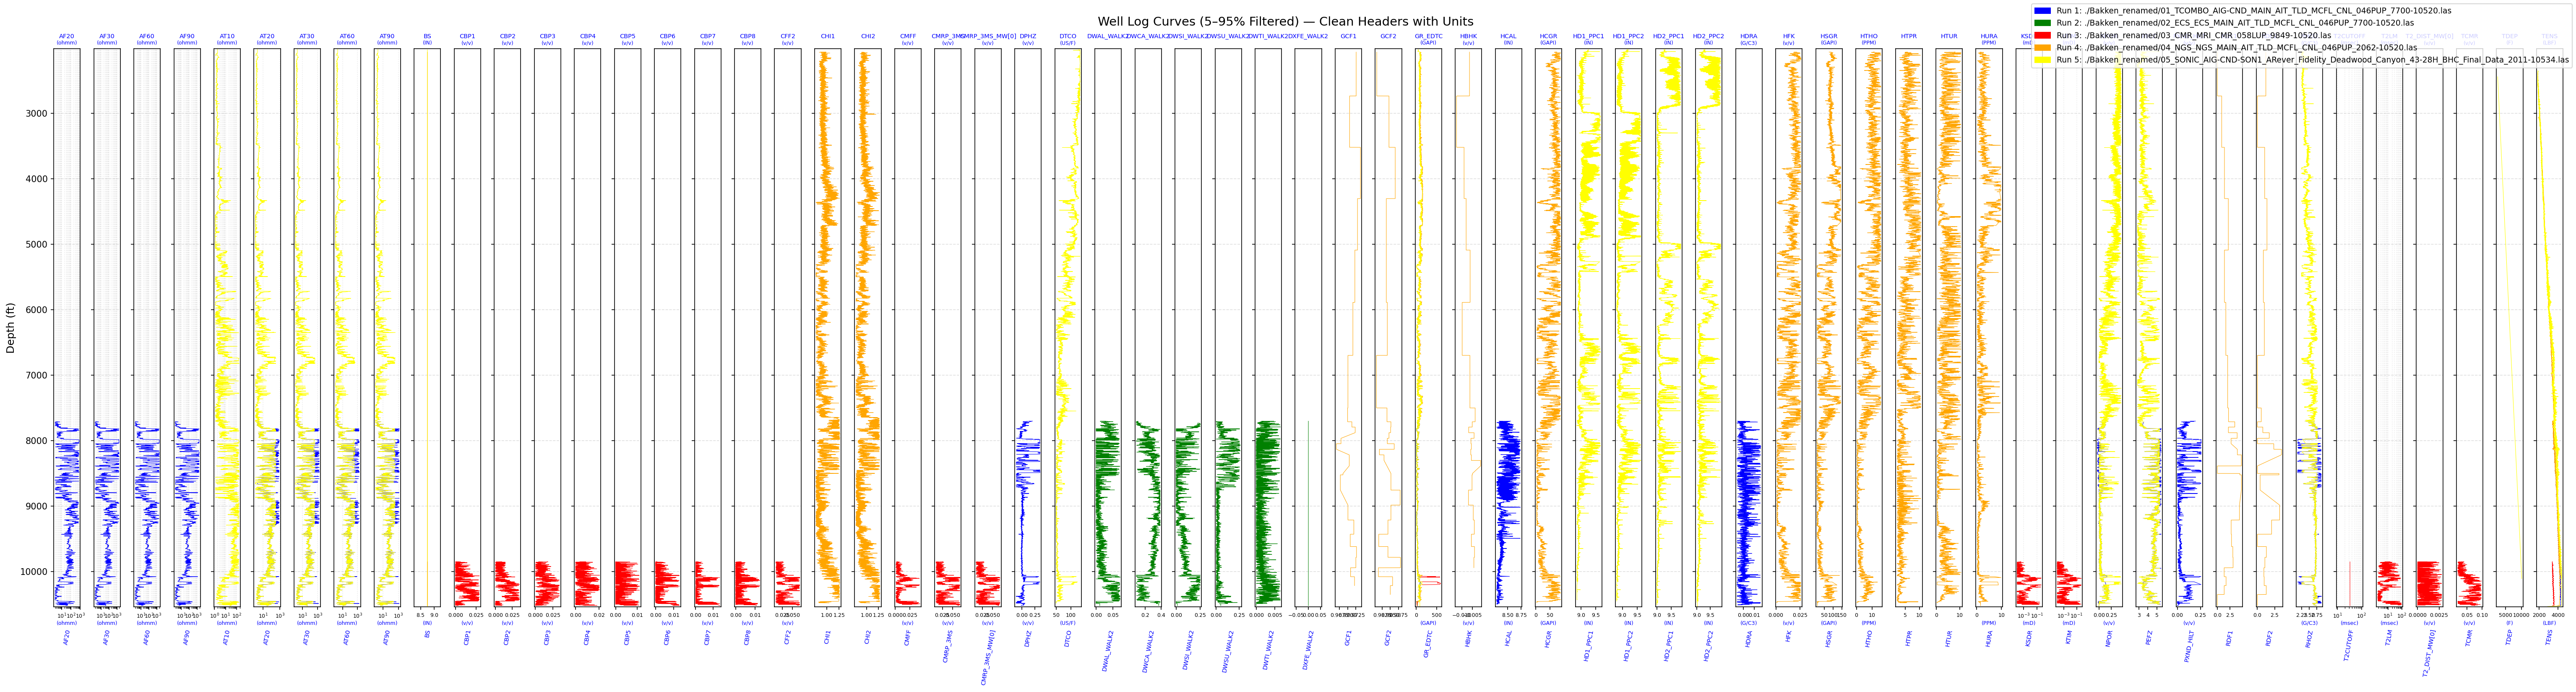

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lasio
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML

# -------------------------------------------------
# Helpers
# -------------------------------------------------
def canonical_unit(u: str) -> str:
    if not u:
        return ""
    su = u.strip().upper().replace(" ", "")

    if su in ["OHMM", "OHM.M", "OHM-M", "OHM/M", "OHM*M", "OHM·M"]:
        return "ohmm"
    if su in ["MD", "MD."]:
        return "mD"
    if su in ["US/FT"]:
        return "µs/ft"
    if su in ["G/CM3", "G/CC"]:
        return "g/cc"
    if su in ["MS", "MSEC"]:
        return "msec"
    if su in ["CFCF", "V/V", "VV"]:
        return "v/v"
        
    return u.strip()


def get_curve_unit(curve, las_data):
    units = []
    for _, _, df, units_map in las_data:
        if curve in df.columns:
            u = canonical_unit(units_map.get(curve, ""))
            if u:
                units.append(u)

    units = sorted(set(units))
    if len(units) == 1:
        return units[0]
    if len(units) > 1:
        return "mixed"
    return ""


def is_log_curve(curve, las_data):
    for _, _, df, units_map in las_data:
        if curve in df.columns:
            if canonical_unit(units_map.get(curve, "")) in ["ohmm", "mD", "msec"]:
                return True
    return False


def safe_log_mask(x):
    return np.isfinite(x) & (x > 0)


# -------------------------------------------------
# Read LAS files
# -------------------------------------------------
def get_filtered_well_data(file):
    las = lasio.read(file)
    df = las.df()
    df.index = las["DEPT"]

    units_map = {c.mnemonic: (c.unit or "") for c in las.curves}

    lo = df.quantile(0.05)
    hi = df.quantile(0.95)

    df_filt = df.apply(
        lambda c: c.where((c >= lo[c.name]) & (c <= hi[c.name]), np.nan),
        axis=0
    )

    wellname = las.well.WELL.value if "WELL" in las.well else file
    return wellname, df.index, df_filt, units_map


las_data = [get_filtered_well_data(f) for f in las_files]

all_curves = sorted(set().union(*[df.columns for _, _, df, _ in las_data]))

min_depth = min(np.nanmin(d) for _, d, _, _ in las_data)
max_depth = max(np.nanmax(d) for _, d, _, _ in las_data)

# -------------------------------------------------
# Plot setup
# -------------------------------------------------
colors = ["blue", "green", "red", "orange", "yellow", "black", "purple", "cyan", "gray", "violet", "limegreen", "teal"]
colors = (colors * 10)[:len(las_files)]

fig, axes = plt.subplots(
    ncols=len(all_curves),
    figsize=(0.65 * len(all_curves), 11),
    sharey=True
)

if len(all_curves) == 1:
    axes = [axes]

legend_handles = [
    mpatches.Patch(color=colors[i], label=f"Run {i+1}: {las_files[i]}")
    for i in range(len(las_files))
]

# -------------------------------------------------
# Plot loop
# -------------------------------------------------
for i, curve in enumerate(all_curves):
    ax = axes[i]

    unit = get_curve_unit(curve, las_data)
    log_scale = is_log_curve(curve, las_data)

    # ---- Top header
    ax.set_title(curve, fontsize=7, color="blue", pad=12)

    # Units below title
    if unit:
        ax.text(
            0.5, 1.015,
            f"({unit})",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=6,
            color="blue"
        )

    # ---- Plot runs
    for run_i, (_, depth, df, _) in enumerate(las_data):
        if curve not in df.columns:
            continue

        x = df[curve].to_numpy(float)
        y = np.asarray(depth, float)

        if log_scale:
            m = safe_log_mask(x) & np.isfinite(y)
        else:
            m = np.isfinite(x) & np.isfinite(y)

        if np.any(m):
            ax.plot(x[m], y[m], lw=0.5, color=colors[run_i])

    # ---- Axes formatting
    ax.set_ylim(max_depth, min_depth)
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    if log_scale:
        ax.set_xscale("log")
        ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.3)

    # ---- Bottom curve label (tilted)
    ax.set_xlabel("")
    ax.text(
        0.5, -0.04,
        curve,
        transform=ax.transAxes,
        fontsize=7,
        rotation=80,
        ha="center",   # key: center at x=0.5
        color="blue",
        va="top",
    )
    # Units below curve label
    if unit:
        ax.text(
            0.5, -0.025,
            f"({unit})",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=6,
            color="blue"
        )

# -------------------------------------------------
# Global formatting
# -------------------------------------------------
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle(
    "Well Log Curves (5–95% Filtered) — Clean Headers with Units",
    fontsize=14
)
fig.legend(handles=legend_handles, loc="upper right", fontsize=9)

plt.tight_layout(w_pad=0.2)

# -------------------------------------------------
# Save + embed
# -------------------------------------------------
buf = BytesIO()
fig.savefig(buf, dpi=150, bbox_inches="tight")
buf.seek(0)

img_b64 = base64.b64encode(buf.read()).decode()
plt.close(fig)

display(HTML(f"""
<div style="overflow-x:auto; border:1px solid #aaa; padding:10px;">
<img src="data:image/png;base64,{img_b64}" style="max-width:none;">
</div>
"""))


## View key logs marked by our Showing Run Numbers:

2011.0
10534.0


Run                                               File  Run Top (ft)  \
0    1  ./Bakken_renamed/01_TCOMBO_AIG-CND_MAIN_AIT_TL...        7700.0   
1    2  ./Bakken_renamed/02_ECS_ECS_MAIN_AIT_TLD_MCFL_...        7700.0   
2    3  ./Bakken_renamed/03_CMR_MRI_CMR_058LUP_9849-10...        9849.0   
3    4  ./Bakken_renamed/04_NGS_NGS_MAIN_AIT_TLD_MCFL_...        2062.0   
4    5  ./Bakken_renamed/05_SONIC_AIG-CND-SON1_ARever_...        2011.0   

   Run Base (ft)  Plot Window Top (ft)  Plot Window Base (ft)  \
0        10520.0                2011.0                10534.0   
1        10520.0                2011.0                10534.0   
2        10520.0                2011.0                10534.0   
3        10520.0                2011.0                10534.0   
4        10534.0                2011.0                10534.0   

                                    Available Curves  
0  AF20, AF30, AF60, AF90, AT20, AT30, AT60, AT90...  
1  DEPT, DWAL_WALK2, DWCA_WALK2, DWSI_WALK2, DWSU...  
2  BS, CBP1, CBP2, CBP3, CBP4, CBP5, CBP6, CBP7, ...  
3  BS, CHI1, CHI2, DEPT, GCF1, GCF2, GR_EDTC, HBH...  
4  AT10, AT20, AT30, AT60, AT90, BS, DEPT, DTCO, ...

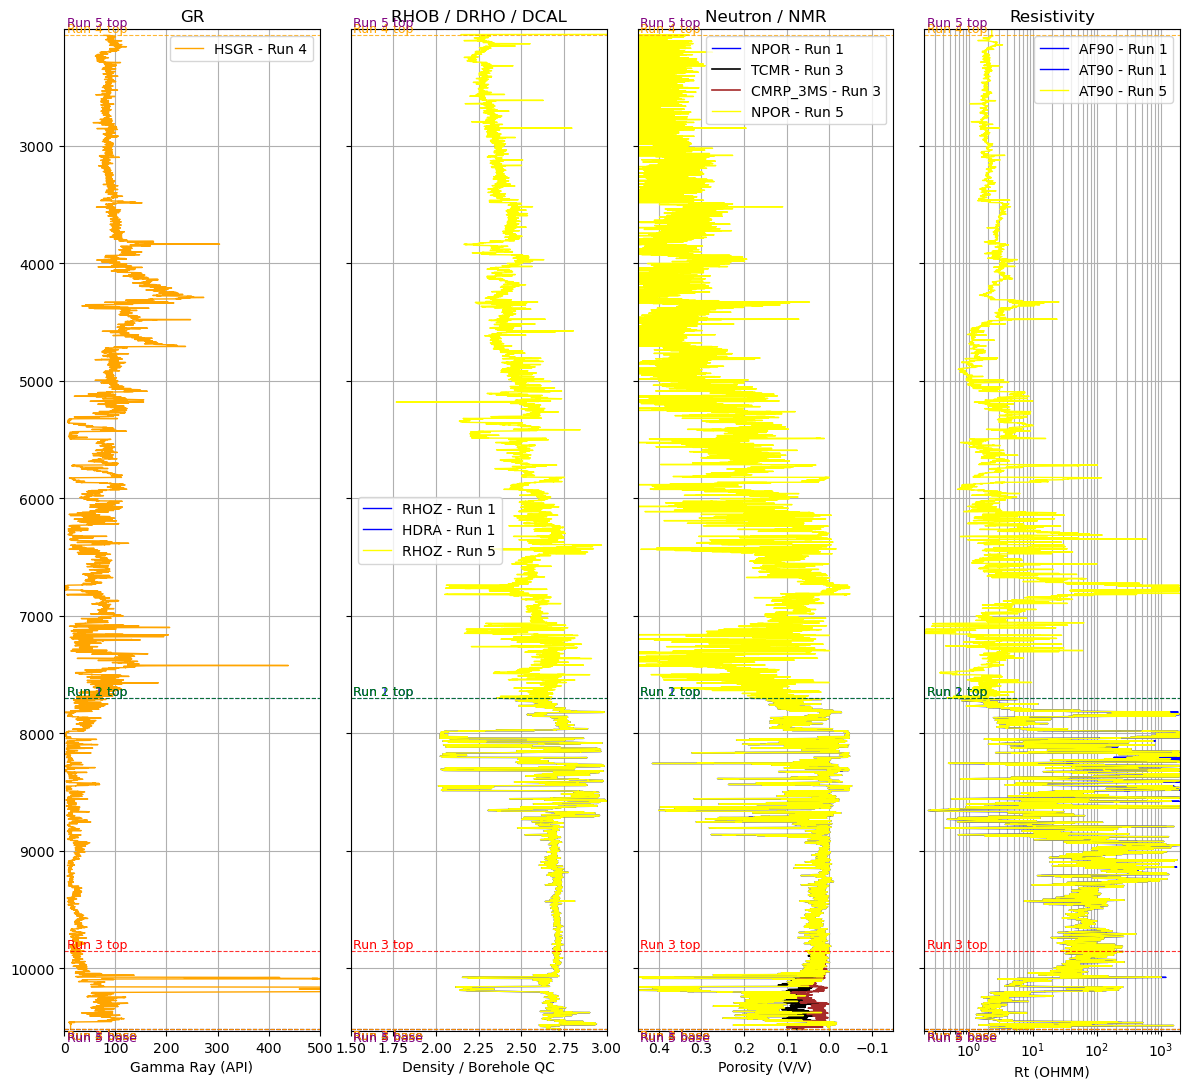

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

# Global depth range across runs
min_depth = min(np.nanmin(depth) for _, depth, _, _ in las_data)
max_depth = max(np.nanmax(depth) for _, depth, _, _ in las_data)

print(min_depth)
print(max_depth)

# -----------------------------
# 1) Define curve families
# -----------------------------
curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2", "CAL", "CALIPER"],
    "DCAL":    ["DCAL", "DCALI", "D_CAL", "CALD"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
    "PERM":    ["PERM", "K", "KH", "KVERT", "KMD", "PERM_MD", "PERM_M", "KLOGH", "KLOG"],
}

curve_style = {
    "RHOB": {"color": "black", "linewidth": 1.2},
    "DRHO": {"color": "red",   "linewidth": 1.0},
    "DCAL": {"color": "purple","linewidth": 1.0},

    "TCMR":     {"color": "black", "linewidth": 1.2},
    "CMRP_3MS": {"color": "brown", "linewidth": 1.2},
    "BFV":      {"color": "blue",  "linewidth": 1.2},
}

fill_between = {
    "track": "POR_NMR",
    "left": "TCMR",
    "right": "BFV",
    "color": "yellow",
    "alpha": 0.35
}

family_plot_config = {
    "RT":   {"xscale": "log"},
    "PERM": {"xscale": "log"},
}

# -----------------------------
# 2) Read LAS files
# -----------------------------
logs = []
for file in las_files:
    las = lasio.read(file)

    depth = np.asarray(las["DEPT"], float)
    depth = depth[np.isfinite(depth)]



    
    top_depth = min_depth
    bottom_depth = max_depth



    
    curve_info = {
        curve.mnemonic: (las[curve.mnemonic].min(), las[curve.mnemonic].max())
        for curve in las.curves
    }

    data = {
        "file": file,
        "depth": las["DEPT"],
        "run_top": float(np.nanmin(depth)) if depth.size else np.nan,
        "run_base": float(np.nanmax(depth)) if depth.size else np.nan,
        #"depth_min": top_depth,
        #"depth_max": bottom_depth,
        "depth_min": min_depth,
        "depth_max": max_depth,
        "curves": curve_info
    }

    needed = set(mn for fam in curve_families.values() for mn in fam)
    for mn in needed:
        data[mn] = las[mn] if mn in las.curves else None

    logs.append(data)

# -----------------------------
# 3) Inventory table with run start/stop
# -----------------------------
df_inventory = pd.DataFrame([
    {
        "Run": i + 1,
        "File": log["file"],
        "Run Top (ft)": log["run_top"],
        "Run Base (ft)": log["run_base"],
        #"Plot Window Top (ft)": log["depth_min"],
        #"Plot Window Base (ft)": log["depth_max"],
        "Plot Window Top (ft)": min_depth,
        "Plot Window Base (ft)": max_depth,
        "Available Curves": ", ".join(sorted(log["curves"].keys()))
    }
    for i, log in enumerate(logs)
])

display(df_inventory)

# -----------------------------
# 4) Helpers
# -----------------------------
def plot_track(ax, track_keys, xlim=None, xscale=None, xlabel="", title=""):
    #colors = ["blue", "green", "red", "orange", "purple", "cyan", "gray", "teal"]
    colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]


    if isinstance(track_keys, str):
        track_keys = [track_keys]

    if xscale is None:
        for k in track_keys:
            cfg = family_plot_config.get(k, {})
            if "xscale" in cfg:
                xscale = cfg["xscale"]
                break

    mnemonics = []
    for key in track_keys:
        mnemonics.extend(curve_families.get(key, []))

    for i, log in enumerate(logs):
        depth = np.asarray(log["depth"], float)

        for mn in mnemonics:
            if log.get(mn) is None:
                continue

            x = np.asarray(log[mn], float)

            if xscale == "log":
                m = (
                    np.isfinite(depth) &
                    np.isfinite(x) &
                    (x > 0) &
                    (depth >= top_depth) &
                    (depth <= bottom_depth)
                )
            else:
                m = (
                    np.isfinite(depth) &
                    np.isfinite(x) &
                    (depth >= top_depth) &
                    (depth <= bottom_depth)
                )

            if not np.any(m):
                continue

            style = {"color": colors[i % len(colors)], "linewidth": 1.0}
            if mn in curve_style:
                style.update(curve_style[mn])

            ax.plot(x[m], depth[m], label=f"{mn} - Run {i+1}", **style)

    ax.set_ylim(top_depth, bottom_depth)
    ax.invert_yaxis()
    if xlim is not None:
        ax.set_xlim(*xlim)
    if xscale is not None:
        ax.set_xscale(xscale)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, which="both")
    ax.legend()

def add_fill_between(ax):
    left = fill_between["left"]
    right = fill_between["right"]

    for log in logs:
        if log.get(left) is None or log.get(right) is None:
            continue

        depth = np.asarray(log["depth"], float)
        x1 = np.asarray(log[left], float)
        x2 = np.asarray(log[right], float)

        m = (
            (depth >= top_depth) &
            (depth <= bottom_depth) &
            np.isfinite(x1) &
            np.isfinite(x2)
        )

        if np.any(m):
            ax.fill_betweenx(
                depth[m],
                x1[m],
                x2[m],
                color=fill_between["color"],
                alpha=fill_between["alpha"]
            )

def add_run_markers(ax):
    """
    Draw run top/base lines for each LAS run and label them.
    Uses the same color cycle as plotting so it visually matches.
    """
    colors = ["blue", "green", "red", "orange", "purple", "cyan", "gray", "teal"]

    # Put labels near the left edge of the track in axes coordinates
    x_text = 0.01

    for i, log in enumerate(logs):
        c = colors[i % len(colors)]
        rt = log.get("run_top", np.nan)
        rb = log.get("run_base", np.nan)

        # Only draw if within plotting window
        if np.isfinite(rt) and (top_depth <= rt <= bottom_depth):
            ax.axhline(rt, color=c, linewidth=0.8, linestyle="--", alpha=0.8)
            ax.text(x_text, rt, f"Run {i+1} top", transform=ax.get_yaxis_transform(),
                    va="bottom", ha="left", fontsize=9, color=c)

        if np.isfinite(rb) and (top_depth <= rb <= bottom_depth):
            ax.axhline(rb, color=c, linewidth=0.8, linestyle="--", alpha=0.8)
            ax.text(x_text, rb, f"Run {i+1} base", transform=ax.get_yaxis_transform(),
                    va="top", ha="left", fontsize=9, color=c)

# -----------------------------
# 5) Plot function
# -----------------------------
def plot_well_logs():
    fig, axes = plt.subplots(1, 4, figsize=(12, 11), sharey=True)

    # Track 1: GR
    plot_track(
        axes[0],
        "GR",
        xlim=(0, 500),
        xlabel="Gamma Ray (API)",
        title="GR"
    )
    add_run_markers(axes[0])

    # Track 2: Density + DRHO + DCAL
    plot_track(
        axes[1],
        ["RHOB", "DRHO", "DCAL"],
        xlim=(1.5, 3.0),
        xlabel="Density / Borehole QC",
        title="RHOB / DRHO / DCAL"
    )
    add_run_markers(axes[1])

    # Track 3: Neutron + NMR
    plot_track(
        axes[2],
        ["TNPH", "POR_NMR"],
        xlim=(0.45, -0.15),
        xlabel="Porosity (V/V)",
        title="Neutron / NMR"
    )
    add_fill_between(axes[2])
    add_run_markers(axes[2])

    # Track 4: Resistivity (log10)
    plot_track(
        axes[3],
        "RT",
        xlim=(0.2, 2000),
        xlabel="Rt (OHMM)",
        title="Resistivity"
    )
    add_run_markers(axes[3])

    plt.tight_layout()
    plt.show()

# Execute
plot_well_logs()


---
---
# **Merge all las file Data:**

Fit any combination of runs.

First plot the merged data as black curves to make sure that this is working:

Recalculate CMR Data to plot TCMR-CMRP_3MS-FFI-BVI_effective

In [6]:
import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML  

# -----------------------------
# Helper: detect OHMM curves (units) and safely plot on log scale
# -----------------------------
def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M", "MD", "MS"])

# Function to read LAS file and extract depth/log data (+ units map)
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()

    # Ensure depth is unique by averaging duplicate values
    df_log = df_log.groupby("DEPT").mean().reset_index()
    df_log.set_index("DEPT", inplace=True)

    # units map: mnemonic -> unit string
    units_map = {c.mnemonic: (c.unit or "") for c in las.curves}

    wellname = las.well.WELL.value if "WELL" in las.well else file  
    return wellname, df_log.index, df_log, units_map

# Read all LAS files
las_data = [get_filtered_well_data(file) for file in las_files]

# Build a combined units map (first non-empty unit wins)
combined_units_map = {}
for _, _, df, units_map in las_data:
    for c in df.columns:
        if c not in combined_units_map or not combined_units_map[c]:
            combined_units_map[c] = units_map.get(c, "") or combined_units_map.get(c, "")

# **Ensure all depths from all LAS files are included in `merged_depth_index`**
all_depths = np.unique(np.concatenate([depth.values for _, depth, _, _ in las_data]))
merged_depth_index = np.sort(all_depths)

# Get all unique well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df, _ in las_data]))

# Create an empty DataFrame for merged data
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_available_curves, dtype=float)

# **Improved Merging Strategy: Preserve Original Data**
for _, depth, df_log, _ in las_data:
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]  # Ensure unique depth values

    for curve in all_available_curves:
        if curve not in df_log.columns:
            continue

        valid_mask = df_log[curve].notna()
        valid_depths = df_log.index[valid_mask]

        if valid_depths.size == 0:
            continue

        # If the curve does not exist in merged_df, assign it directly
        if merged_df.loc[valid_depths, curve].isna().all():
            merged_df.loc[valid_depths, curve] = df_log.loc[valid_depths, curve].astype(float)
        else:
            # Merge using a weighted approach in overlapping regions
            overlap_mask = merged_df.loc[valid_depths, curve].notna()

            # Fill where merged is empty
            merged_df.loc[valid_depths[~overlap_mask], curve] = df_log.loc[valid_depths[~overlap_mask], curve].astype(float)

            # Blend overlap (favor newer run)
            merged_df.loc[valid_depths[overlap_mask], curve] = (
                df_log.loc[valid_depths[overlap_mask], curve].astype(float) * 0.7 +
                merged_df.loc[valid_depths[overlap_mask], curve].astype(float) * 0.3
            )





# ===========================================================
# NMR PARTITIONING (RUN ONCE, AFTER MERGE IS DONE)  ✅
# - CBW  = TCMR - CMRP_3MS               (gray fill between PHIE and PHIT)
# - BVI_E = PHIE - CMFF                  (dark blue fill from 0 to BVI_E)
# - FFI_E = CMFF (clipped to [0, PHIE])  (yellow fill between BVI_E and PHIE)
#
# Outputs added to merged_df:
#   PHIT_NMR, PHIE_NMR, CBW, BVI_E, FFI_E
# Optional QC:
#   BFV_minus_CBW_BVI_E  (if BFV exists)
# ===========================================================

def clip0(x):
    x = np.asarray(x, float)
    return np.where(np.isfinite(x), np.maximum(x, 0.0), np.nan)

# ---- set your curve names here ----
TCMR_COL = "TCMR"        # total porosity
EFF_COL  = "CMRP_3MS"    # effective porosity
CMFF_COL = "CMFF"        # effective free fluid (if present)
BFV_COL  = "BFV"         # (optional) total bound = CBW + BVI (vendor-specific)

df = merged_df  # or merged_df.copy() if you want to preserve raw merged_df

have_tcmr = TCMR_COL in df.columns
have_eff  = EFF_COL  in df.columns
have_cmff = CMFF_COL in df.columns

if have_tcmr and have_eff:

    # --- pull arrays ---
    tcmr_raw = df[TCMR_COL].astype(float).to_numpy()
    eff_raw  = df[EFF_COL ].astype(float).to_numpy()

    # --- QC / physical sanity ---
    # Total porosity can't be negative
    tcmr = clip0(tcmr_raw)

    # Effective porosity can't be negative and can't exceed total porosity
    eff = clip0(eff_raw)
    eff = np.where(np.isfinite(eff) & np.isfinite(tcmr), np.minimum(eff, tcmr), eff)

    # --- store cleaned bases for plotting ---
    df["PHIT_NMR"] = tcmr
    df["PHIE_NMR"] = eff

    # --- Clay Bound Water (total system) ---
    cbw = clip0(tcmr - eff)
    cbw = np.where(np.isfinite(cbw) & np.isfinite(tcmr), np.minimum(cbw, tcmr), cbw)
    df["CBW"] = cbw

    # --- Effective-system FFI and BVI ---
    if have_cmff:
        cmff_raw = df[CMFF_COL].astype(float).to_numpy()

        # FFI should be within [0, PHIE]
        ffi_e = np.where(np.isfinite(cmff_raw) & np.isfinite(eff),
                         np.clip(cmff_raw, 0.0, eff),
                         np.nan)

        bvi_e = clip0(eff - ffi_e)

        df["FFI_E"] = ffi_e
        df["BVI_E"] = bvi_e

    else:
        df["FFI_E"] = np.nan
        df["BVI_E"] = np.nan

    # --- Optional reconciliation / QC vs BFV ---
    if BFV_COL in df.columns and have_cmff:
        bfv = df[BFV_COL].astype(float).to_numpy()
        # If BFV truly equals CBW + BVI (definitions vary), this should hover near 0
        df["BFV_minus_CBW_BVI_E"] = bfv - (df["CBW"] + df["BVI_E"])

else:
    print("NMR partition skipped: need both TCMR and CMRP_3MS present in merged_df.")


# Update curve list after adding derived curves (CBW/BVIE/FFI/PHIT_NMR/PHIE_NMR)
all_available_curves = sorted(merged_df.columns.tolist())

# Black and White Plot of all Curves:

Plot saved as Merged_Depth_plot_DEADWOOD_CANYON_RANCH_43-28H_Bakken_renamed_black&white.png



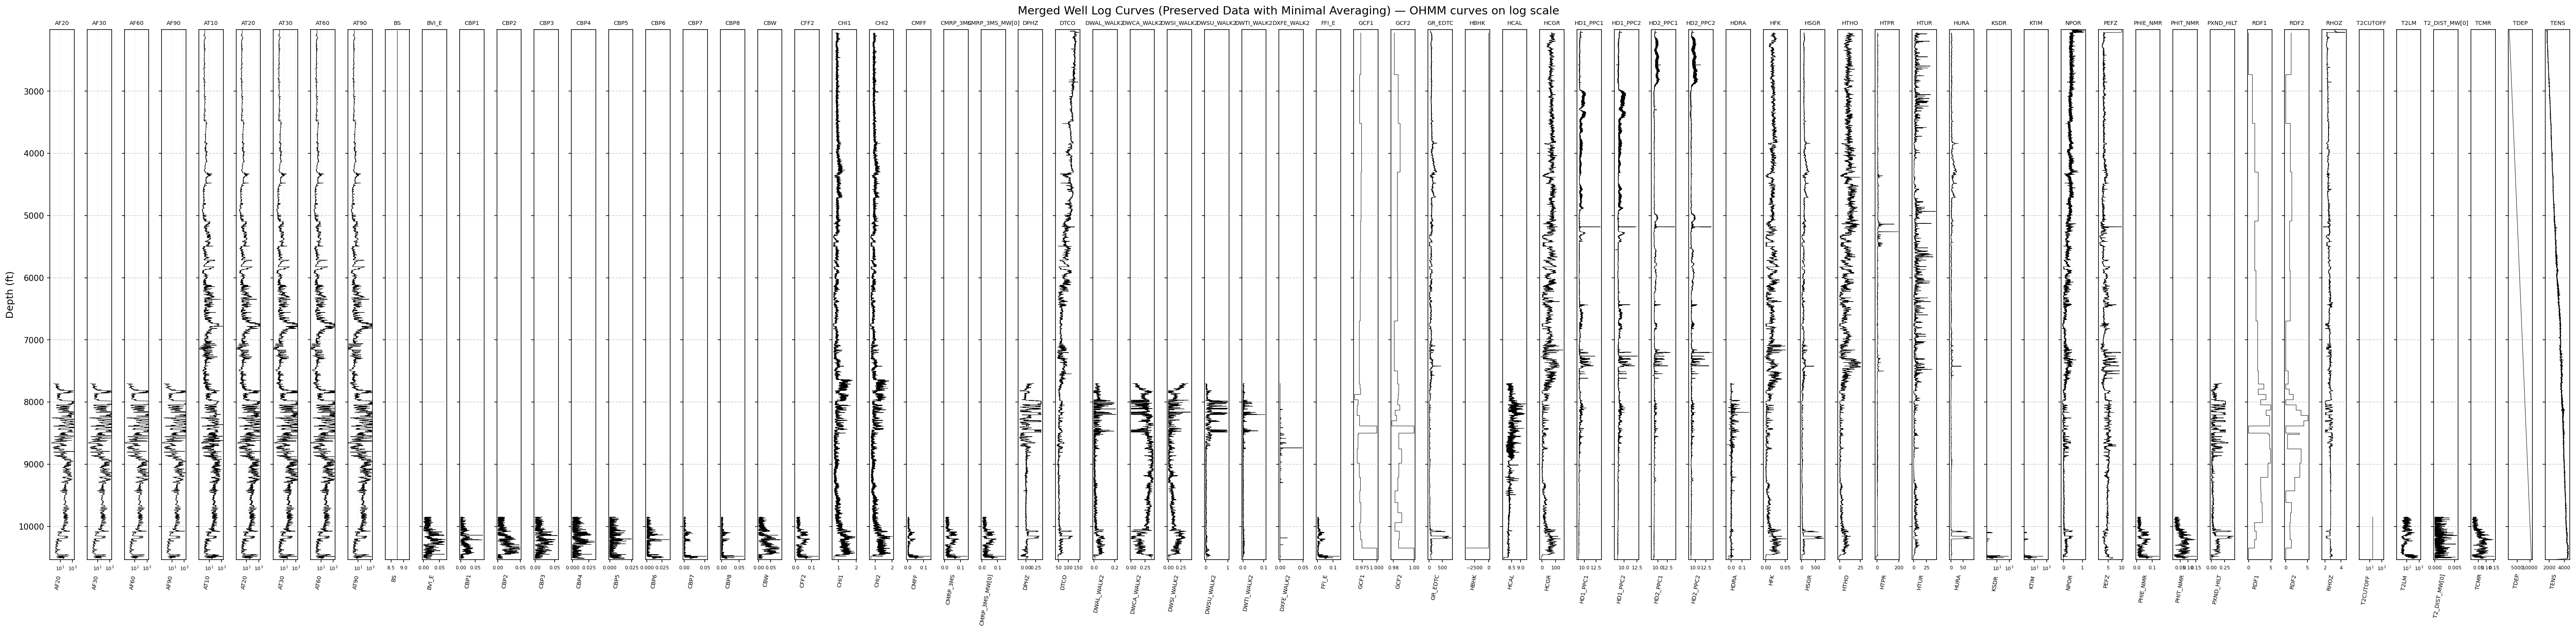

In [7]:
# -----------------------------
# Plot the merged well log curves
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# If only one curve, axes is not a list; normalize
if len(all_available_curves) == 1:
    axes = [axes]

for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Determine if curve should be log-scale (OHMM units)
    curve_is_log = is_ohmm_curve(curve, combined_units_map)

    # Extract data
    x = merged_df[curve].to_numpy(dtype=float)
    y = merged_depth_index.astype(float)

    # Plot with proper masking for log scale
    if np.isfinite(x).any():
        if curve_is_log:
            m = np.isfinite(x) & np.isfinite(y) & (x > 0)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.5, color="black")
                ax.set_xscale("log")
                ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.35)
                ax.set_xlim(0.2,2000)
            else:
                # nothing valid for log scale
                pass
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.5, color="black")

    # Formatting
    ax.set_ylim(merged_depth_index[-1], merged_depth_index[0])  # Depth increases downward
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Preserved Data with Minimal Averaging) — OHMM curves on log scale", fontsize=14)

# Output filename using first run's wellname (consistent)
wellname0 = (las_data[0][0] if las_data else "WELL").replace("#", "").replace(" ", "_")

plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = f"Merged_Depth_plot_{wellname0}_{file_directory}_black&white.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


# **QC Check** - *merged data as thin yellow curves plotted over individual runs color by las file:*

Plot saved as Merged_Depth_plot_DEADWOOD_CANYON_RANCH_43-28H_Bakken_renamed_yellow-line_plotted-over-colored-individual-las-files_QC-check.png



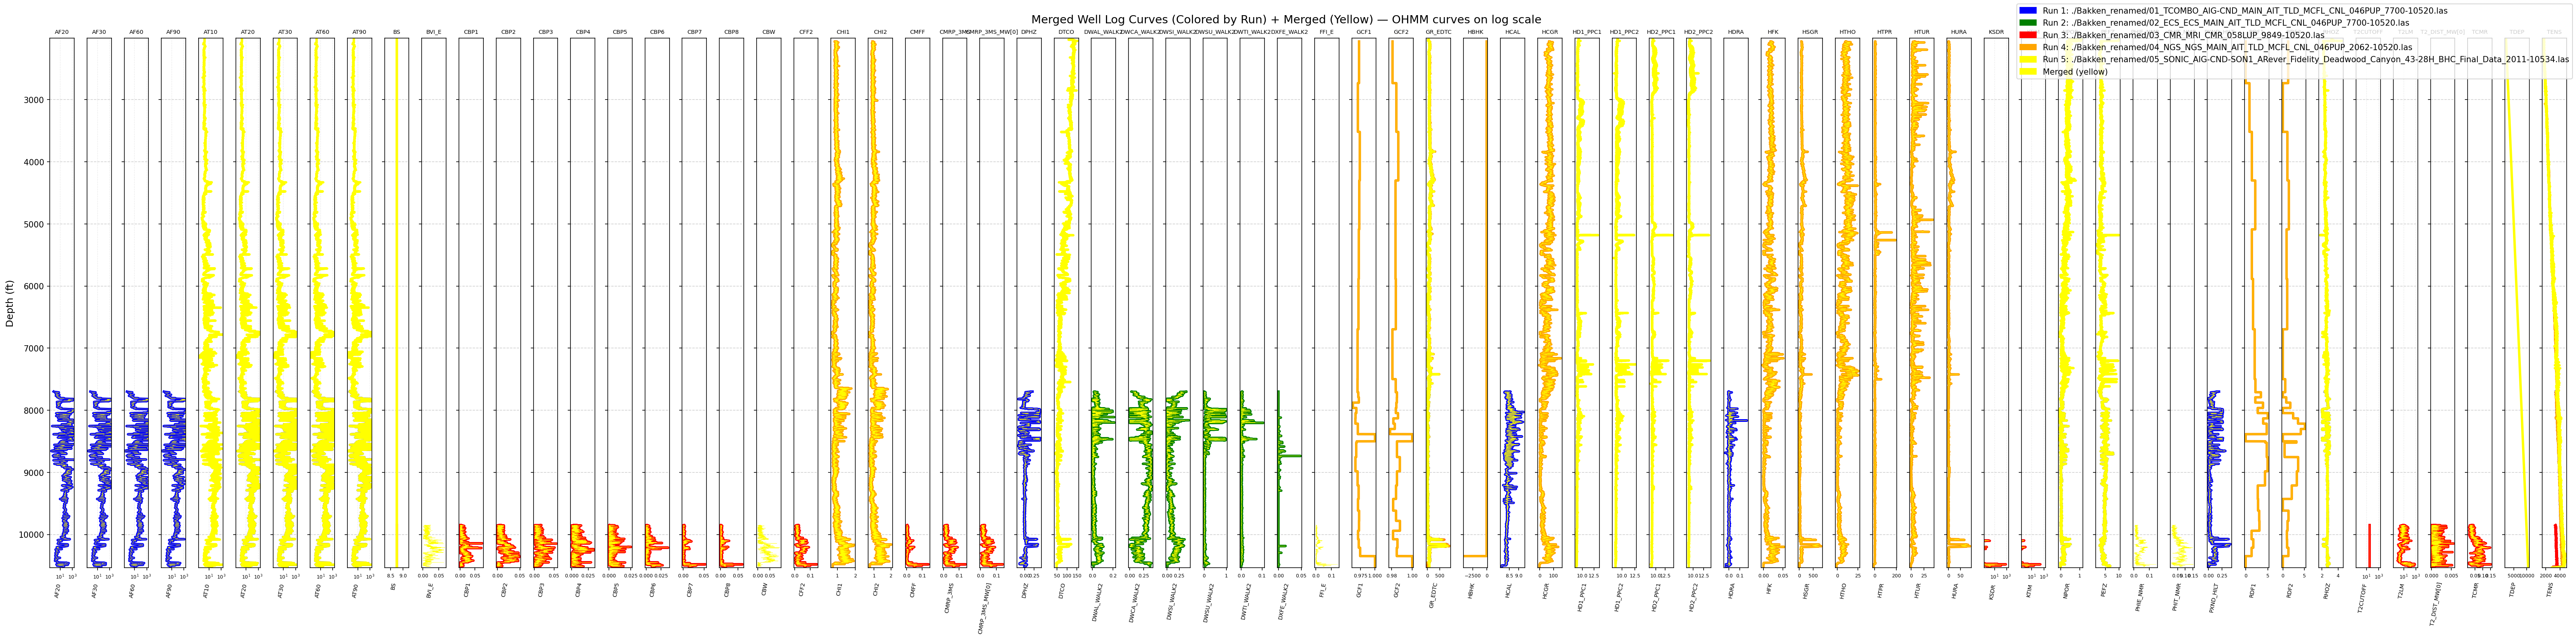

In [8]:
# -----------------------------
# Plot setup (colored by run + merged in yellow)
# -----------------------------
# Colors for each run
#run_colors = ["blue", "green", "red", "orange", "yellow", "black", "purple", "cyan", "gray", "violet", "limegreen"]
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]

if len(las_files) > len(run_colors):
    run_colors = (run_colors * (len(las_files) // len(run_colors) + 1))[:len(las_files)]

# Global depth range (for consistent axes)
min_depth = min(np.nanmin(depth) for _, depth, _, _ in las_data)
max_depth = max(np.nanmax(depth) for _, depth, _, _ in las_data)

legend_patches = [mpatches.Patch(color=run_colors[i], label=f"Run {i+1}: {las_files[i]}") for i in range(len(las_files))]
legend_patches.append(mpatches.Patch(color="yellow", label="Merged (yellow)"))

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# If only one curve, axes is not a list; normalize
if len(all_available_curves) == 1:
    axes = [axes]

for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Determine if curve should be log-scale (OHMM units)
    curve_is_log = is_ohmm_curve(curve, combined_units_map)

    # -------------------------
    # Colored plots by run
    # -------------------------
    for run_index, (wellname, depth, df_filtered, _) in enumerate(las_data):
        if curve not in df_filtered.columns or not df_filtered[curve].notna().any():
            continue

        x = df_filtered[curve].to_numpy(dtype=float)
        y = np.asarray(depth, float)

        if curve_is_log:
            m = safe_log_mask(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=3, color=run_colors[run_index], alpha=1.0)
                ax.set_xlim(0.2,2000)
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=3, color=run_colors[run_index], alpha=1.0)

    # -------------------------
    # Plot merged curve (yellow)
    # -------------------------
    if curve in merged_df.columns and merged_df[curve].notna().any():
        x = merged_df[curve].to_numpy(dtype=float)
        y = merged_depth_index.astype(float)

        if curve_is_log:
            m = safe_log_mask(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.25, color="yellow", alpha=1.0)
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.25, color="yellow", alpha=1.0)

    # Axis formatting
    ax.set_ylim(max_depth, min_depth)
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Apply log scaling for OHMM curves
    if curve_is_log:
        ax.set_xscale("log")
        ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.35)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Colored by Run) + Merged (Yellow) — OHMM curves on log scale", fontsize=14)
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

# Save and display the image
plt.tight_layout(pad=1.0, w_pad=0.2)

# Use first run's wellname for filename stability
wellname0 = (las_data[0][0] if las_data else "WELL").replace("#", "").replace(" ", "_")
image_filename = f"Merged_Depth_plot_{wellname0}_{file_directory}_yellow-line_plotted-over-colored-individual-las-files_QC-check.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# **Save all Merged data to las and csv files:**

In [9]:
# ===========================================================
# MERGE LAS RUNS  ➜  build merged_df  ➜  add NMR partition curves
#                 ➜  update units map for NEW curves
#                 ➜  (optional) write CSV + LAS
# ===========================================================

import numpy as np
import pandas as pd
import lasio

# -----------------------------
# USER SETTINGS
# -----------------------------
# assumes you already built las_files + file_directory in a prior cell
# las_files = [...]
# file_directory = "MAG1" (or whatever folder)

# -----------------------------
# Helper: detect OHMM curves (units) and safely plot on log scale
# -----------------------------
def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M", "MD", "MS"])

def clip0(x):
    """clip to >=0, keep NaN where non-finite"""
    x = np.asarray(x, dtype=float)
    return np.where(np.isfinite(x), np.maximum(x, 0.0), np.nan)

# -----------------------------
# Read LAS and return df + units
# -----------------------------
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()

    # Ensure depth unique by averaging duplicate values
    # (las.df() index is DEPT; we force explicit groupby)
    df_log = df_log.groupby("DEPT").mean().reset_index()
    df_log.set_index("DEPT", inplace=True)

    units_map = {c.mnemonic: (c.unit or "") for c in las.curves}
    wellname = las.well.WELL.value if "WELL" in las.well else file
    return wellname, df_log.index, df_log, units_map

# -----------------------------
# Sanity check
# -----------------------------
if "las_files" not in globals() or not las_files:
    raise ValueError("`las_files` is empty. Run your folder-selection cell first.")

# -----------------------------
# Read all LAS files
# -----------------------------
las_data = [get_filtered_well_data(file) for file in las_files]

# Build a combined units map (first non-empty unit wins)
combined_units_map = {}
for _, _, df, units_map in las_data:
    for c in df.columns:
        if c not in combined_units_map or not combined_units_map[c]:
            combined_units_map[c] = units_map.get(c, "") or combined_units_map.get(c, "")

# Ensure all depths from all LAS files are included
all_depths = np.unique(np.concatenate([depth.values for _, depth, _, _ in las_data]))
merged_depth_index = np.sort(all_depths)

# Get all unique curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df, _ in las_data]))

# Create empty merged DF
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_available_curves, dtype=float)

# -----------------------------
# Merge strategy: preserve data; blend overlap
# -----------------------------
for _, depth, df_log, _ in las_data:
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]

    for curve in all_available_curves:
        if curve not in df_log.columns:
            continue

        valid_mask = df_log[curve].notna()
        valid_depths = df_log.index[valid_mask]
        if valid_depths.size == 0:
            continue

        if merged_df.loc[valid_depths, curve].isna().all():
            merged_df.loc[valid_depths, curve] = df_log.loc[valid_depths, curve].astype(float)
        else:
            overlap_mask = merged_df.loc[valid_depths, curve].notna()

            # fill where merged is empty
            merged_df.loc[valid_depths[~overlap_mask], curve] = df_log.loc[valid_depths[~overlap_mask], curve].astype(float)

            # blend overlap (favor newer run)
            merged_df.loc[valid_depths[overlap_mask], curve] = (
                df_log.loc[valid_depths[overlap_mask], curve].astype(float) * 0.7 +
                merged_df.loc[valid_depths[overlap_mask], curve].astype(float) * 0.3
            )

# ===========================================================
# NMR PARTITIONING (AFTER merge, on merged_df)
# Creates:
#   PHIT_NMR  = TCMR
#   PHIE_NMR  = CMRP_3MS
#   CBW       = max(PHIT_NMR - PHIE_NMR, 0)
#   FFI       = clip(CMFF, 0..PHIE_NMR)   (if CMFF exists)
#   BVIE      = max(PHIE_NMR - FFI, 0)    (if CMFF exists)
# ===========================================================
TCMR_COL = "TCMR"
EFF_COL  = "CMRP_3MS"
CMFF_COL = "CMFF"   # if present

have_tcmr = TCMR_COL in merged_df.columns
have_eff  = EFF_COL  in merged_df.columns
have_cmff = CMFF_COL in merged_df.columns

if have_tcmr and have_eff:
    tcmr = merged_df[TCMR_COL].astype(float).to_numpy()
    eff  = merged_df[EFF_COL].astype(float).to_numpy()

    merged_df["PHIT_NMR"] = tcmr
    merged_df["PHIE_NMR"] = eff
    merged_df["CBW"]      = clip0(tcmr - eff)

    if have_cmff:
        cmff = merged_df[CMFF_COL].astype(float).to_numpy()

        # clip CMFF to [0, PHIE]
        cmff_clip = np.where(
            np.isfinite(cmff) & np.isfinite(eff),
            np.clip(cmff, 0.0, eff),
            np.nan
        )

        merged_df["FFI"]  = cmff_clip
        merged_df["BVIE"] = clip0(eff - cmff_clip)
    else:
        merged_df["FFI"]  = np.nan
        merged_df["BVIE"] = np.nan

else:
    print("NMR partition skipped: need both TCMR and CMRP_3MS present in merged_df.")

# ===========================================================
# UNITS UPDATE MODULE (goes RIGHT HERE)
# This makes your plots show units for the NEW curves, and lets
# your LAS writer carry units if you choose to pass them through.
# ===========================================================
combined_units_map.update({
    "PHIT_NMR": "v/v",
    "PHIE_NMR": "v/v",
    "CBW":      "v/v",
    "FFI":      "v/v",
    "BVIE":     "v/v",
})
# (optional) ensure vendor curves also have porosity units if blank
combined_units_map.setdefault("TCMR", "v/v")
combined_units_map.setdefault("CMRP_3MS", "v/v")
combined_units_map.setdefault("CMFF", "v/v")
combined_units_map.setdefault("BFV", "v/v")

print("✅ merged_df built with NMR partition curves:", [c for c in ["PHIT_NMR","PHIE_NMR","CBW","FFI","BVIE"] if c in merged_df.columns])

# ===========================================================
# OPTIONAL: WRITE CSV + LAS (uses updated units)
# ===========================================================
# --- Extract well metadata from the first LAS file ---
las_first = lasio.read(las_files[0])

well_metadata = {
    "COMPANY": las_first.well.COMP.value if "COMP" in las_first.well else "Unknown",
    "WELL":    las_first.well.WELL.value if "WELL" in las_first.well else "Unknown",
    "FIELD":   las_first.well.FLD.value  if "FLD"  in las_first.well else "Unknown",
    "COUNTY":  las_first.well.CNTY.value if "CNTY" in las_first.well else "Unknown",
    "STATE":   las_first.well.STAT.value if "STAT" in las_first.well else "Unknown",
}

well_name_cleaned = str(well_metadata["WELL"]).replace("#", "").replace(" ", "_")

csv_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.csv"
las_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.las"

# --- Save CSV ---
merged_df.to_csv(csv_filename, index=True)
print(f"✅ CSV saved: {csv_filename}")

# --- Save LAS ---
las_merged = lasio.LASFile()
las_merged.well.WELL = well_name_cleaned
las_merged.well.COMP = well_metadata["COMPANY"]
las_merged.well.FLD  = well_metadata["FIELD"]
las_merged.well.CNTY = well_metadata["COUNTY"]
las_merged.well.STAT = well_metadata["STATE"]

# Depth curve first
las_merged.append_curve("DEPT", merged_df.index.values, unit="ft", descr="Depth")

# Add each curve with unit from combined_units_map (if available)
for curve in merged_df.columns:
    unit = (combined_units_map.get(curve, "") or "").strip()
    las_merged.append_curve(curve, merged_df[curve].values, unit=unit, descr=curve)

las_merged.write(las_filename, version=2.0, wrap=False)
print(f"✅ LAS saved: {las_filename}")


✅ merged_df built with NMR partition curves: ['PHIT_NMR', 'PHIE_NMR', 'CBW', 'FFI', 'BVIE']
✅ CSV saved: Merged_Well_Log_DEADWOOD_CANYON_RANCH_43-28H_Bakken_renamed.csv
✅ LAS saved: Merged_Well_Log_DEADWOOD_CANYON_RANCH_43-28H_Bakken_renamed.las


---
---
# Comprehensive Plot from Merged Data

This is CMR data, but BFV from CMR is in the total porosity system and so is TCMR. However CMRP_3MS is in the effective porosity system. Therefore, we take the difference between TCMR and CMRP_3MS as Clay Bound Water (CBW) and subtract that from the BFV to calculate a BVI in the effective porosity system. Our CMR plot then goes from TCMR to CMRP_3MS shaded in as gray for the CBW volume. We then plot BVI_effective as a dark blue fill on the right side of track and then shade the difference between BVI_effective and CMRP_3ms as yellow to represent the Free Fluid (FFI) volume. FFI is the only available pore space for hydrocarbons, and there is a strong correlation between FFI and permeability. 


✅ Auto zone from PHIT_NMR: 9849.0 – 10520.0 ft


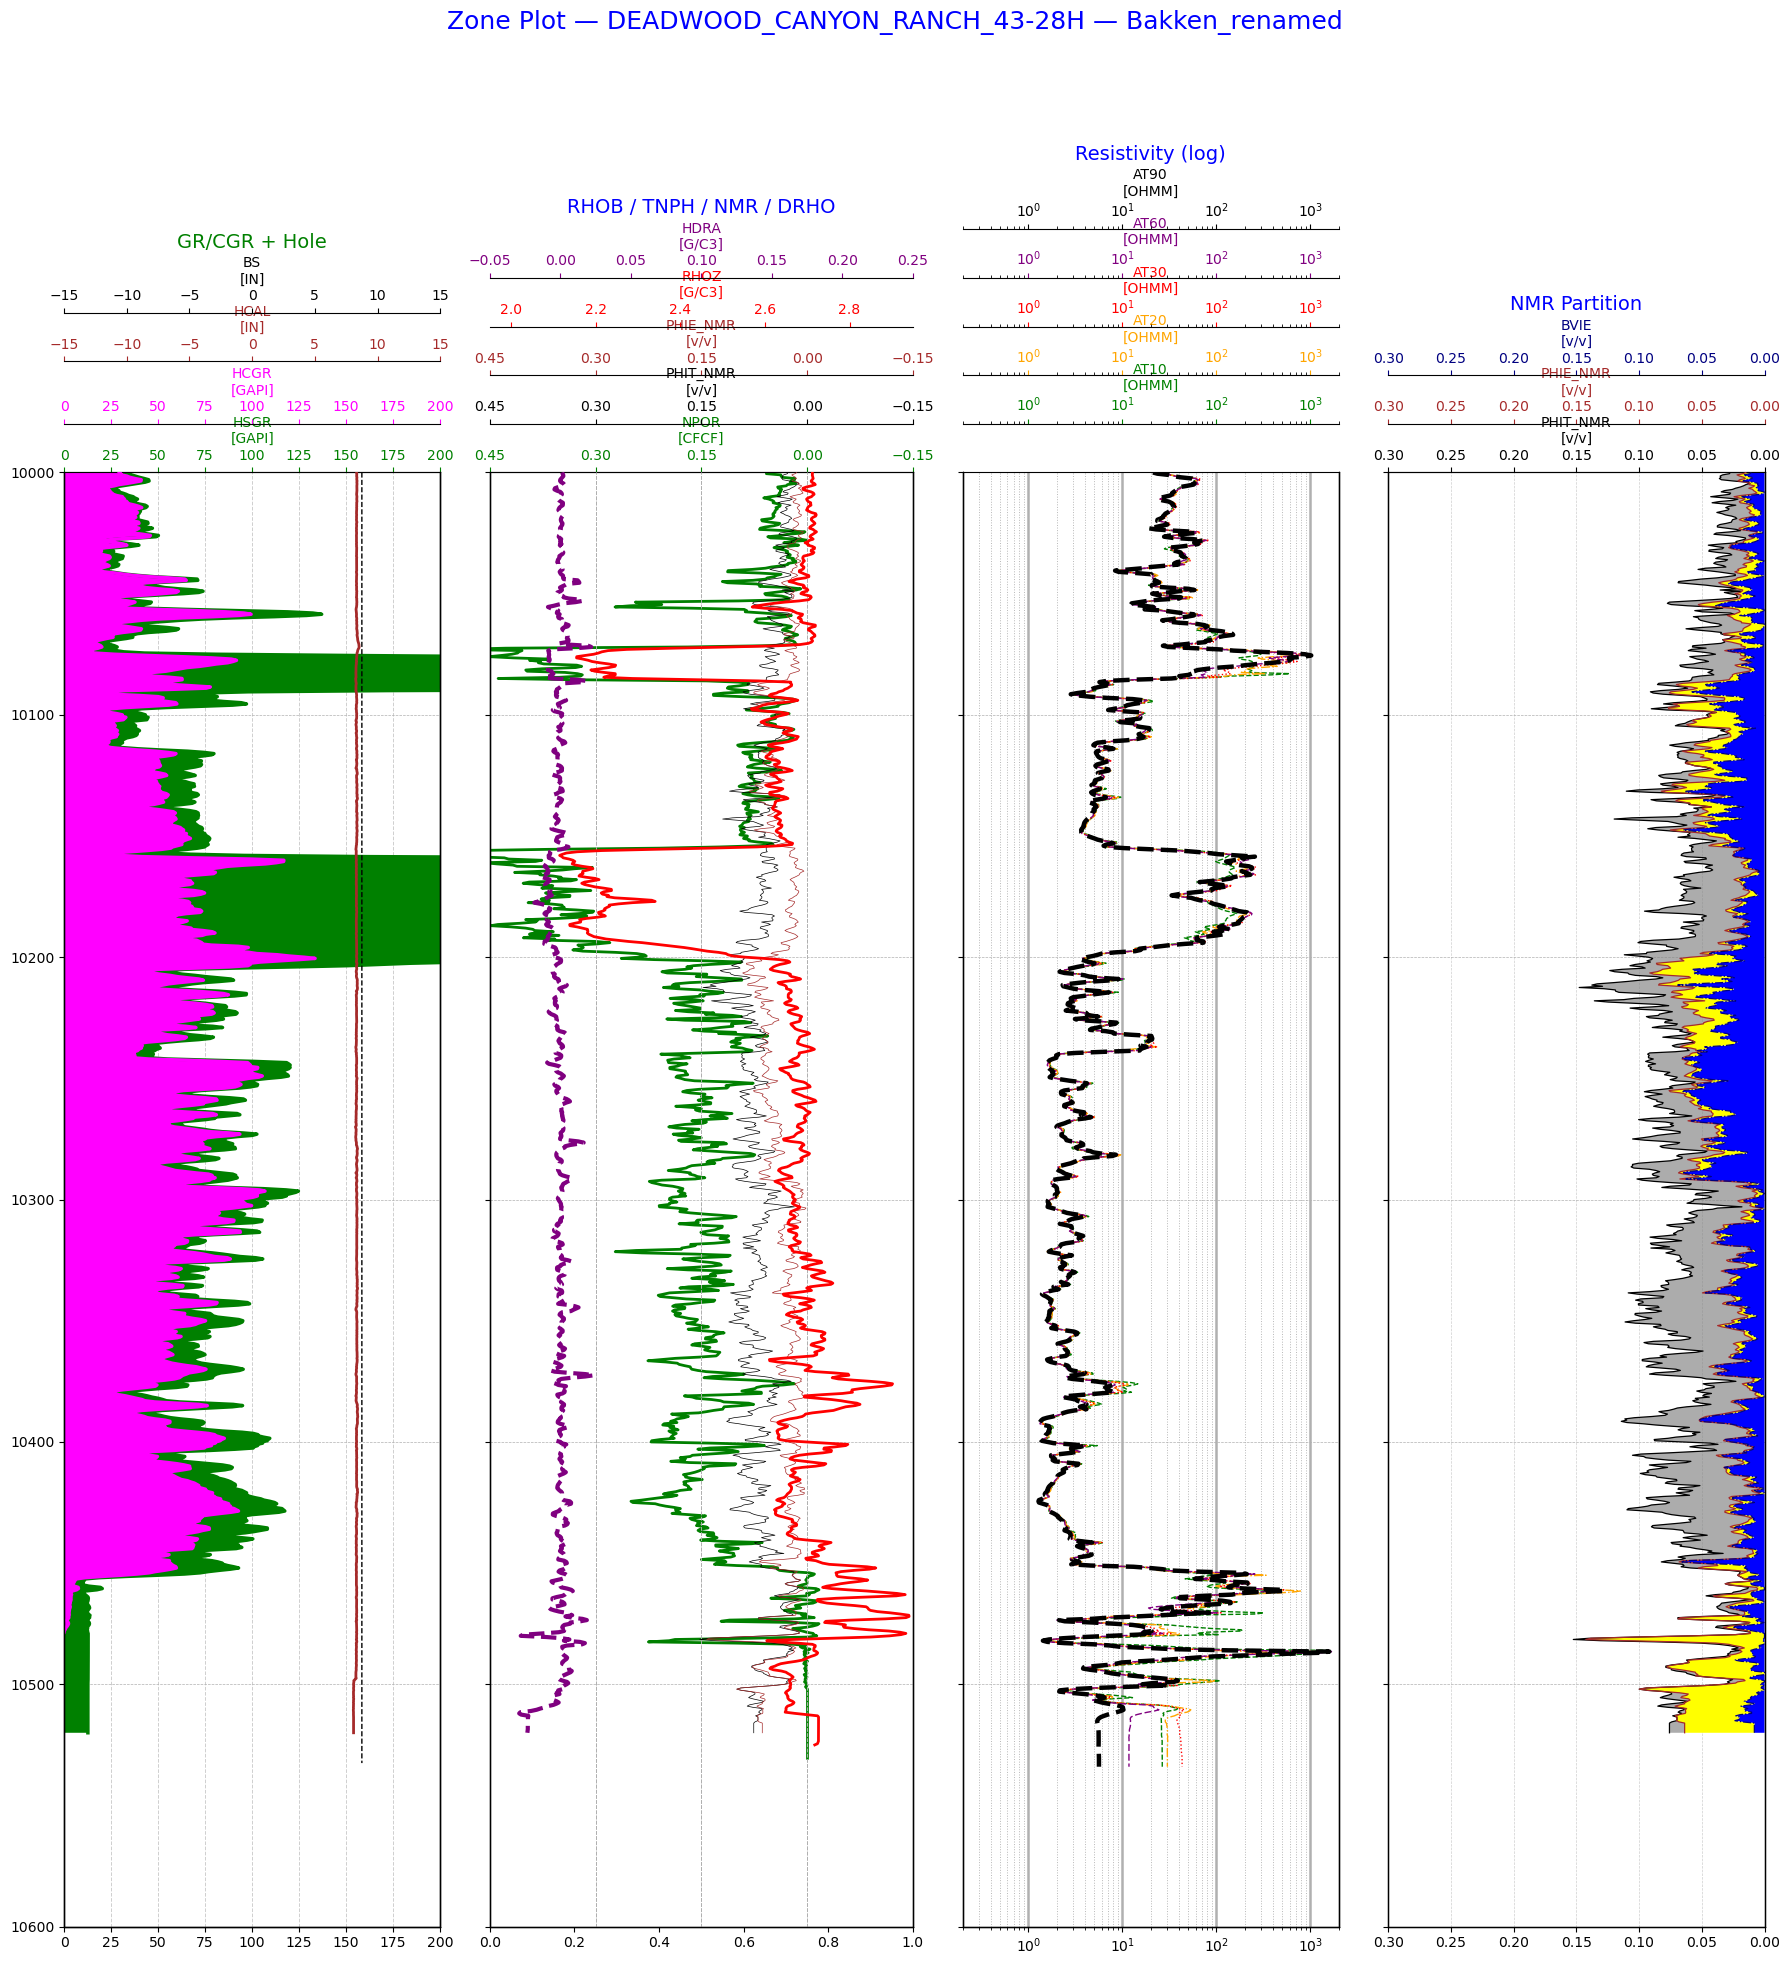

In [10]:
# ===========================================================
# ZONE TEMPLATE PLOT — from merged_df (in-memory) + NMR partition curves
# Track layout (4 tracks):
#   1) GR/CGR + Hole (CALI/BS/DCAL)
#   2) RHOB / TNPH / PHIT_NMR / PHIE_NMR / DRHO
#   3) Resistivity family (log)
#   4) NMR partition: CBW / FFI / BVIE (+ optional BFV QC)
# ===========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter



# -----------------------------
# USER INPUTS
# -----------------------------
#top_summary = 9850
#bottom_summary = 10520

# -----------------------------
# Helpers
# -----------------------------
def nice_label(mnemonic, units_map):
    u = (units_map.get(mnemonic, "") or "").strip() if isinstance(units_map, dict) else ""
    return f"{mnemonic}\n[{u}]" if u else mnemonic

def first_present(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def add_tops(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d in tops_depths:
            if top_depth <= d <= bottom_depth:
                ax.axhline(d, color="red", linewidth=1.0)

def add_tops_labels(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d, nm in zip(tops_depths, tops):
            if top_depth <= d <= bottom_depth:
                ax.text(
                    0.02, d, str(nm),
                    transform=ax.get_yaxis_transform(),
                    ha="left", va="center",
                    color="red", fontsize=10
                )

def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    if not isinstance(units_map, dict):
        return False
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M"])

# -----------------------------
# AUTO top_summary / bottom_summary from PHIT_NMR coverage
# -----------------------------
import numpy as np

def nmr_depth_limits_from_curve(df, curve="PHIT_NMR", zone_top=None, zone_base=None):
    """
    Returns (top_depth, base_depth) where df[curve] is finite.
    Optional zone_top/zone_base restrict the search window.
    """
    if df is None or df.empty or curve not in df.columns:
        raise ValueError(f"{curve} not present in df.")

    d = df.copy()
    d = d.sort_index()

    if zone_top is not None and zone_base is not None:
        d = d.loc[(d.index >= zone_top) & (d.index <= zone_base)]

    m = np.isfinite(d[curve].to_numpy(dtype=float)) & np.isfinite(d.index.to_numpy(dtype=float))
    if not np.any(m):
        raise ValueError(f"No finite values found for {curve} (after optional zone filter).")

    depths = d.index.to_numpy(dtype=float)[m]
    return float(np.min(depths)), float(np.max(depths))

# Option A (most common): use FULL PHIT_NMR coverage
top_summary, bottom_summary = nmr_depth_limits_from_curve(merged_df, curve="PHIT_NMR")
print(f"✅ Auto zone from PHIT_NMR: {top_summary:.1f} – {bottom_summary:.1f} ft")


# -----------------------------
# USER INPUTS
# -----------------------------
top_summary = 10000
bottom_summary = 10600




# Option B: if you want to constrain to a broader zone first (example)
# top_summary, bottom_summary = nmr_depth_limits_from_curve(
#     merged_df, curve="PHIT_NMR", zone_top=9700, zone_base=10600
# )


def setup_porosity_axis(a):
    """
    Standard porosity axis:
    - Range: 0.45 → -0.15 (inverted)
    - Gridlines at [-0.15, 0.00, 0.15, 0.30, 0.45]
    """
    ticks = [-0.15, 0.00, 0.15, 0.30, 0.45]
    a.set_xlim(-0.15, 0.45)
    a.invert_xaxis()
    a.set_xticks(ticks)
    a.grid(True, axis="x", linestyle="--", linewidth=0.7, alpha=0.8)








# -----------------------------
# Plot function (FROM DF)
# -----------------------------
def plot_zone_template_from_df(df_in, units_map, top_depth, bottom_depth, title=None):
    if df_in is None or df_in.empty:
        raise ValueError("merged_df is empty.")

    df = df_in.copy()
    df.index.name = df.index.name or "DEPT"
    df = df.sort_index()

    z = df.loc[(df.index >= top_depth) & (df.index <= bottom_depth)].copy()
    if z.empty:
        raise ValueError(f"No data in zone {top_depth}–{bottom_depth}.")

    # -----------------------------
    # Candidate lists
    # -----------------------------
    # Track 1 GR/CGR
    gr_cands  = ["GR", "SGR", "HGR", "HSGR"]
    cgr_cands = ["CGR", "HCGR"]

    # Track 1 hole (moved here)
    cali_cands = ["CALI","CALS","HCAL","CAL","CALIPER","HD1_PPC1","HD2_PPC1"]
    bs_cands   = ["BS","BITSIZE","BIT","BIT_SIZE"]
    dcal_cands = ["DCAL","DCALI","D_CAL","CALD"]

    # Track 2
    rhob_cands = ["RHOB", "RHOZ"]
    drho_cands = ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"]
    tnph_cands = ["TNPH", "NPHI", "NPOR", "CNL"]
    tcmr_cands = ["PHIT_NMR", "TCMR", "MPHIS"]
    cmrp_cands = ["PHIE_NMR", "CMRP_3MS", "CMRP3MS", "CMRP", "MPHI"]

    # Track 3 resistivity
    rxo_cands  = ["RXOZ", "Rxo", "RXO", "RxoZ"]
    at90_cands = ["AT90", "AF90", "AO90", "ILD", "RT"]
    at60_cands = ["AT60", "AF60", "AO60"]
    at30_cands = ["AT30", "AF30", "AO30"]
    at20_cands = ["AT20", "AF20", "AO20"]
    at10_cands = ["AT10", "AF10", "AO10"]

    # Track 4 NMR partition
    cbw_cands  = ["CBW"]
    bvie_cands = ["BVIE","BVI_E"]
    ffi_cands  = ["FFI", "CMFF"]   # prefer FFI if you created it; CMFF fallback
    bfv_cands  = ["BFV","BFV_3MS","BFV3MS","MBVI"]  # optional QC

    # -----------------------------
    # Pick curves
    # -----------------------------
    gr   = first_present(z.columns, gr_cands)
    cgr  = first_present(z.columns, cgr_cands)

    cali = first_present(z.columns, cali_cands)
    bs   = first_present(z.columns, bs_cands)
    dcal = first_present(z.columns, dcal_cands)

    rhob = first_present(z.columns, rhob_cands)
    drho = first_present(z.columns, drho_cands)
    tnph = first_present(z.columns, tnph_cands)
    tcmr = first_present(z.columns, tcmr_cands)  # PHIT_NMR preferred
    cmrp = first_present(z.columns, cmrp_cands)  # PHIE_NMR preferred

    rxo  = first_present(z.columns, rxo_cands)
    at90 = first_present(z.columns, at90_cands)
    at60 = first_present(z.columns, at60_cands)
    at30 = first_present(z.columns, at30_cands)
    at20 = first_present(z.columns, at20_cands)
    at10 = first_present(z.columns, at10_cands)

    cbw  = first_present(z.columns, cbw_cands)
    bvie = first_present(z.columns, bvie_cands)
    ffi  = first_present(z.columns, ffi_cands)
    bfv  = first_present(z.columns, bfv_cands)

    # -----------------------------
    # Create 4 tracks
    # -----------------------------
    fig, ax = plt.subplots(
        nrows=1, ncols=4, figsize=(18, 20), sharey=True,
        gridspec_kw={"width_ratios": [1.6, 1.8, 1.6, 1.6]}
    )

    if title is None:
        title = f"Zone Template Plot — {top_depth:g}–{bottom_depth:g} ft"
    fig.suptitle(title, fontsize=18, color="blue")
    fig.subplots_adjust(top=0.92, wspace=0.22)

    # Common Y formatting
    for a in ax:
        a.set_ylim(top_depth, bottom_depth)
        a.invert_yaxis()
        a.yaxis.grid(True, linestyle="--", linewidth=0.5)
        a.get_xaxis().set_visible(True)
        add_tops(a, top_depth, bottom_depth)
    add_tops_labels(ax[0], top_depth, bottom_depth)

    depth = z.index.values

    # ==========================================================
    # Track 1: GR/CGR fills + Hole condition (CALI/BS/DCAL)
    # ==========================================================
    ax[0].set_title("GR/CGR + Hole", fontsize=14, color="green")

    # ---- GR/CGR scale ----
    x_left_gr, x_right_gr = 0.0, 200.0
    ax[0].set_xlim(x_left_gr, x_right_gr)
    ax[0].grid(True, axis="x", linestyle="--", linewidth=0.7, alpha=0.6)

    # FILL axis for GR/CGR
    a_fill_gr = ax[0].twiny()
    a_fill_gr.set_xlim(x_left_gr, x_right_gr)
    a_fill_gr.spines["top"].set_visible(False)
    a_fill_gr.get_xaxis().set_visible(False)
    a_fill_gr.grid(False)

    gr_vals  = z[gr].astype(float).values if gr else None
    cgr_vals = z[cgr].astype(float).values if cgr else None

    # 0 -> CGR (magenta)
    if cgr_vals is not None:
        a_fill_gr.fill_betweenx(
            depth, 0.0, cgr_vals,
            where=np.isfinite(cgr_vals),
            facecolor="magenta", alpha=1.0
        )

    # CGR -> GR (green)
    if (gr_vals is not None) and (cgr_vals is not None):
        a_fill_gr.fill_betweenx(
            depth, cgr_vals, gr_vals,
            where=np.isfinite(gr_vals) & np.isfinite(cgr_vals) & (gr_vals >= cgr_vals),
            facecolor="green", alpha=1.0
        )

    # optional: 0->GR if no CGR
    if (gr_vals is not None) and (cgr_vals is None):
        a_fill_gr.fill_betweenx(
            depth, 0.0, gr_vals,
            where=np.isfinite(gr_vals),
            facecolor="green", alpha=0.25
        )

    # Curves on top (separate twiny labels)
    if gr:
        a = ax[0].twiny()
        a.set_xlim(x_left_gr, x_right_gr)
        a.plot(gr_vals, depth, color="green", linewidth=2.5)
        a.set_xlabel(nice_label(gr, units_map), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        a.grid(False)

    if cgr:
        a = ax[0].twiny()
        a.set_xlim(x_left_gr, x_right_gr)
        a.plot(cgr_vals, depth, color="magenta", linewidth=2.5)
        a.set_xlabel(nice_label(cgr, units_map), color="magenta")
        a.tick_params(axis="x", colors="magenta")
        a.spines["top"].set_position(("outward", 35))
        a.grid(False)

    # ---- Hole condition overlay on Track 1 (separate scale) ----
    # CALI/BS: 5–25; DCAL: -2–2
    cali_min, cali_max = -15.0, 15.0
    dcal_min, dcal_max = -5.0, 5.0

    # CALI
    if cali:
        a = ax[0].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(z[cali].astype(float).values, depth, color="brown", linewidth=2.0)
        a.set_xlabel(nice_label(cali, units_map), color="brown")
        a.tick_params(axis="x", colors="brown")
        a.spines["top"].set_position(("outward", 80))
        a.grid(False)

    # BS
    if bs:
        a = ax[0].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(z[bs].astype(float).values, depth, color="black", linewidth=1.0, linestyle="--")
        a.set_xlabel(nice_label(bs, units_map), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 115))
        a.grid(False)

    # Washout fill between BS and CALI where CALI > BS
    if cali and bs:
        cali_vals_h = z[cali].astype(float).values
        bs_vals_h   = z[bs].astype(float).values

        a_fill_h = ax[0].twiny()
        a_fill_h.set_xlim(cali_min, cali_max)
        a_fill_h.spines["top"].set_visible(False)
        a_fill_h.get_xaxis().set_visible(False)
        a_fill_h.grid(False)

        a_fill_h.fill_betweenx(
            depth, bs_vals_h, cali_vals_h,
            where=np.isfinite(cali_vals_h) & np.isfinite(bs_vals_h) & (cali_vals_h > bs_vals_h),
            facecolor="yellow", alpha=0.25
        )

    # DCAL signed fill + curve
    if dcal:
        DC = z[dcal].astype(float).values

        a_fill_d = ax[0].twiny()
        a_fill_d.set_xlim(dcal_min, dcal_max)
        a_fill_d.spines["top"].set_visible(False)
        a_fill_d.get_xaxis().set_visible(False)
        a_fill_d.grid(False)

        a_fill_d.fill_betweenx(
            depth, 0.0, np.clip(DC, 0.0, None),
            where=np.isfinite(DC) & (DC > 0),
            facecolor="yellow", alpha=0.45
        )
        a_fill_d.fill_betweenx(
            depth, np.clip(DC, None, 0.0), 0.0,
            where=np.isfinite(DC) & (DC < 0),
            facecolor="saddlebrown", alpha=0.45
        )

        a = ax[0].twiny()
        a.set_xlim(dcal_min, dcal_max)
        a.plot(DC, depth, color="purple", linewidth= 4.0, linestyle="--")
        a.set_xlabel(nice_label(dcal, units_map), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 150))
        a.grid(False)





    # ==========================================================
    # Track 2: RHOB / TNPH / PHIT / PHIE / DRHO
    # ==========================================================
    ax[1].set_title("RHOB / TNPH / NMR / DRHO", fontsize=14, color="blue")
    
    overlay_done = False
    depth = z.index.values
    
    # --- TNPH ---
    if tnph:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(z[tnph].values, depth, color="green", linewidth=2.0)
        a.set_xlabel(nice_label(tnph, units_map), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        overlay_done = True
    
    # --- PHIT (TCMR / PHIT_NMR) ---
    if tcmr:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(z[tcmr].values, depth, color="black", linewidth=0.5)
        a.set_xlabel(nice_label(tcmr, units_map), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 35))
        overlay_done = True
    
    # --- PHIE (CMRP / PHIE_NMR) ---
    if cmrp:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(z[cmrp].values, depth, color="brown", linewidth=0.5)
        a.set_xlabel(nice_label(cmrp, units_map), color="brown")
        a.tick_params(axis="x", colors="brown")
        a.spines["top"].set_position(("outward", 70))
        overlay_done = True
    
    # --- RHOB ---
    if rhob:
        a = ax[1].twiny()
        a.set_xlim(1.95, 2.95)
        a.plot(z[rhob].values, depth, color="red", linewidth=2)
        a.set_xlabel(nice_label(rhob, units_map), color="red")
        a.tick_params(axis="x", colors="red")
        a.spines["top"].set_position(("outward", 105))
        a.grid(False)
        overlay_done = True
    
    # --- DRHO ---
    if drho:
        a = ax[1].twiny()
        a.set_xlim(-0.05, 0.25)  # or (-2, 2) if that is your scale
        a.plot(z[drho].values, depth, color="purple", linewidth=3, linestyle="--")
        a.set_xlabel(nice_label(drho, units_map), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 140))
        a.grid(False)
        overlay_done = True
    
    if not overlay_done:
        ax[1].text(
            0.5, 0.5,
            "No RHOB / TNPH / NMR / DRHO",
            transform=ax[1].transAxes,
            ha="center", va="center"
        )
    



    # ==========================================================
    # Track 3: Resistivity (log) — proper oilfield grid
    # ==========================================================
    ax[2].set_title("Resistivity (log)", fontsize=14, color="blue")
    
    # --- Log scale ---
    ax[2].set_xscale("log")
    ax[2].set_xlim(0.2, 2000)
    
    # --- Major ticks at 1, 10, 100, 1000 ---
    ax[2].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
    
    # --- Minor ticks at 2–9 within each decade ---
    ax[2].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1))
    ax[2].xaxis.set_minor_formatter(NullFormatter())
    
    # --- Grid styling ---
    # Heavy major grid (1, 100, 1000)
    ax[2].grid(which="major", axis="x", linestyle="-", linewidth=1.8, alpha=1.0)
    
    # Light minor grid (log subdivisions)
    ax[2].grid(which="minor", axis="x", linestyle=":", linewidth=0.7, alpha=0.9)
    
    # --------------------------
    # Plot resistivity curves
    # --------------------------
    res_curves = [
        ("RXO",  rxo,  "blue",   "-",         1.0,   0),
        ("AT10", at10, "green",  "--",        1.0,  35),
        ("AT20", at20, "orange", "-.",        1.0,  70),
        ("AT30", at30, "red",    ":",         1.0, 105),
        ("AT60", at60, "purple", (0, (5, 2)), 1.0, 140),
        ("AT90", at90, "black",  "--",        3.2, 175),
    ]
    
    any_res = False
    for _, c, color, ls, lw, off in res_curves:
        if c:
            a = ax[2].twiny()
            a.set_xscale("log")
            a.set_xlim(0.2, 2000)
            a.plot(z[c].values, depth, color=color, linestyle=ls, linewidth=lw)
            a.set_xlabel(nice_label(c, units_map), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
            any_res = True
    
    if not any_res:
        ax[2].text(
            0.5, 0.5, "No resistivity curves",
            transform=ax[2].transAxes,
            ha="center", va="center"
        )


    

    # ==========================================================
    # Track 4: NMR Partition (CBW gray, FFI yellow, BVI_E blue)
    #   - Gray:   PHIT_NMR -> PHIE_NMR   (CBW)
    #   - Yellow: PHIE_NMR -> BVI_E      (FFI)
    #   - Blue:   0 -> BVI_E            (BVI_E)
    # ==========================================================
    ax[3].set_title("NMR Partition", fontsize=14, color="blue")
    
    x_left, x_right = 0.0, 0.30
    ax[3].set_xlim(x_left, x_right)
    ax[3].invert_xaxis()
    ax[3].grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)
    
    any_nmr = False
    depth = z.index.values
    
    # --- pick the curves (you already selected tcmr/cmrp earlier) ---
    # In your code, tcmr points to PHIT_NMR (or TCMR), cmrp points to PHIE_NMR (or CMRP_3MS)
    phit = z[tcmr].astype(float).values if tcmr else None
    phie = z[cmrp].astype(float).values if cmrp else None
    
    # We will use BVI_E if it exists; otherwise compute it from CMFF if possible
    bvie_name = first_present(z.columns, ["BVI_E", "BVIE"])
    cmff_name = first_present(z.columns, ["FFI", "CMFF"])  # your merged block stores FFI; vendor sometimes CMFF
    
    bvie = z[bvie_name].astype(float).values if bvie_name else None
    
    if bvie is None and (phie is not None) and cmff_name:
        cmff = z[cmff_name].astype(float).values
        cmff_clip = np.where(np.isfinite(cmff) & np.isfinite(phie), np.clip(cmff, 0.0, phie), np.nan)
        bvie = np.where(np.isfinite(phie) & np.isfinite(cmff_clip), np.maximum(phie - cmff_clip, 0.0), np.nan)
    
    # Hidden fill axis so all fills align perfectly
    a_fill = ax[3].twiny()
    a_fill.set_xlim(x_left, x_right)
    a_fill.invert_xaxis()
    a_fill.spines["top"].set_visible(False)
    a_fill.get_xaxis().set_visible(False)
    a_fill.grid(False)
    
    # -------------------------
    # FILLS (your requested logic)
    # -------------------------
    
    # Blue: 0 -> BVI_E
    if bvie is not None:
        a_fill.fill_betweenx(
            depth, 0.0, bvie,
            where=np.isfinite(bvie),
            facecolor="blue", alpha=1.0, label="BVI_E"
        )
        any_nmr = True
    
    # Yellow: PHIE_NMR -> BVI_E  (only where PHIE >= BVI_E)
    if (phie is not None) and (bvie is not None):
        a_fill.fill_betweenx(
            depth, bvie, phie,
            where=np.isfinite(phie) & np.isfinite(bvie) & (phie >= bvie),
            facecolor="yellow", alpha=1.0, label="FFI"
        )
        any_nmr = True
    
    # Gray: PHIT_NMR -> PHIE_NMR  (only where PHIT >= PHIE)
    if (phit is not None) and (phie is not None):
        a_fill.fill_betweenx(
            depth, phie, phit,
            where=np.isfinite(phit) & np.isfinite(phie) & (phit >= phie),
            facecolor="gray", alpha=0.65, label="CBW"
        )
        any_nmr = True
    
    # -------------------------
    # CURVES ON TOP (optional, but useful)
    # -------------------------
    for curve_name, color, off, lw, ls in [
        (tcmr,     "black",  0,   0.9, "-"),   # PHIT_NMR
        (cmrp,     "brown", 35,   0.9, "-"),   # PHIE_NMR
        (bvie_name,"navy",  70,   0.9, "-."),  # BVI_E
    ]:
        if curve_name and curve_name in z.columns:
            a = ax[3].twiny()
            a.set_xlim(x_left, x_right)
            a.invert_xaxis()
            a.plot(z[curve_name].values, depth, color=color, linewidth=lw, linestyle=ls)
            a.set_xlabel(nice_label(curve_name, units_map), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
            any_nmr = True
    
    if not any_nmr:
        ax[3].text(0.5, 0.5, "No NMR curves", transform=ax[3].transAxes, ha="center", va="center")
        
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    return fig

# -----------------------------
# RUN IT
# -----------------------------
_units = combined_units_map if "combined_units_map" in globals() else {}

_title = None
if "well_name_cleaned" in globals() and "file_directory" in globals():
    _title = f"Zone Plot — {well_name_cleaned} — {file_directory}"

fig = plot_zone_template_from_df(
    merged_df,
    _units,
    top_summary,
    bottom_summary,
    title=_title
)
plt.show()





# Range Sliders for Depth Plot:

In [11]:
# ===========================================================
# INTERACTIVE ZONE TEMPLATE PLOT — from merged_df + NMR partition curves
# Track layout (4 tracks):
#   1) GR/CGR + Hole (CALI/BS/DCAL)
#   2) RHOB / TNPH / PHIT_NMR / PHIE_NMR / DRHO   (porosity grid at -0.15,0,.15,.3,.45)
#   3) Resistivity family (log)                    (oilfield grid: heavy decades)
#   4) NMR partition: CBW gray (PHIT->PHIE), FFI yellow (PHIE->BVIE), BVI blue (0->BVIE)
#
# Requires:
#   - merged_df (DataFrame indexed by DEPT)
# Optional:
#   - combined_units_map (dict: mnemonic -> units)
#   - tops_depths, tops
#   - well_name_cleaned, file_directory
# ===========================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter

import ipywidgets as widgets
from IPython.display import display

# -----------------------------
# Helpers
# -----------------------------
def nice_label(mnemonic, units_map):
    u = (units_map.get(mnemonic, "") or "").strip() if isinstance(units_map, dict) else ""
    return f"{mnemonic}\n[{u}]" if u else mnemonic

def first_present(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def add_tops(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d in tops_depths:
            if top_depth <= d <= bottom_depth:
                ax.axhline(d, color="red", linewidth=1.0)

def add_tops_labels(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d, nm in zip(tops_depths, tops):
            if top_depth <= d <= bottom_depth:
                ax.text(
                    0.02, d, str(nm),
                    transform=ax.get_yaxis_transform(),
                    ha="left", va="center",
                    color="red", fontsize=10
                )

def setup_porosity_axis(a):
    """Porosity axis: 0.45 -> -0.15 (inverted) with requested grid ticks."""
    ticks = [-0.15, 0.00, 0.15, 0.30, 0.45]
    a.set_xlim(-0.15, 0.45)
    a.invert_xaxis()
    a.set_xticks(ticks)
    a.grid(True, axis="x", linestyle="--", linewidth=0.7, alpha=0.8)

def nmr_depth_limits_from_curve(df, curve="PHIT_NMR", zone_top=None, zone_base=None):
    """Return (top_depth, base_depth) where df[curve] is finite."""
    if df is None or df.empty or curve not in df.columns:
        raise ValueError(f"{curve} not present in df.")
    d = df.sort_index()
    if zone_top is not None and zone_base is not None:
        d = d.loc[(d.index >= zone_top) & (d.index <= zone_base)]
    m = np.isfinite(d[curve].to_numpy(dtype=float)) & np.isfinite(d.index.to_numpy(dtype=float))
    if not np.any(m):
        raise ValueError(f"No finite values found for {curve} (after optional zone filter).")
    depths = d.index.to_numpy(dtype=float)[m]
    return float(np.min(depths)), float(np.max(depths))

def build_units_map_for_df(df, base_units=None):
    """
    Ensure we have a units map for plotting labels.
    - start from combined_units_map if provided
    - add blanks for any computed curves not present in LAS units
    """
    u = dict(base_units) if isinstance(base_units, dict) else {}
    for c in df.columns:
        if c not in u:
            u[c] = ""
    # Give the computed NMR curves a reasonable unit label if you want:
    for c in ["PHIT_NMR", "PHIE_NMR", "FFI", "BVIE", "BVI_E", "CBW"]:
        if c in df.columns and not u.get(c, ""):
            u[c] = "v/v"
    return u

# -----------------------------
# Main plot function (FROM DF)
# -----------------------------
def plot_zone_template_from_df(df_in, units_map, top_depth, bottom_depth, title=None):
    if df_in is None or df_in.empty:
        raise ValueError("merged_df is empty.")

    df = df_in.copy().sort_index()
    df.index.name = df.index.name or "DEPT"

    z = df.loc[(df.index >= top_depth) & (df.index <= bottom_depth)].copy()
    if z.empty:
        raise ValueError(f"No data in zone {top_depth}–{bottom_depth}.")

    # -----------------------------
    # Candidate lists
    # -----------------------------
    # Track 1 GR/CGR
    gr_cands  = ["GR", "SGR", "HGR", "HSGR"]
    cgr_cands = ["CGR", "HCGR"]

    # Track 1 hole
    cali_cands = ["CALI","CALS","HCAL","CAL","CALIPER","HD1_PPC1","HD2_PPC1"]
    bs_cands   = ["BS","BITSIZE","BIT","BIT_SIZE"]
    dcal_cands = ["DCAL","DCALI","D_CAL","CALD"]

    # Track 2
    rhob_cands = ["RHOB", "RHOZ"]
    drho_cands = ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"]
    tnph_cands = ["TNPH", "NPHI", "NPOR", "CNL"]
    tcmr_cands = ["PHIT_NMR", "TCMR", "MPHIS"]
    cmrp_cands = ["PHIE_NMR", "CMRP_3MS", "CMRP3MS", "CMRP", "MPHI"]

    # Track 3 resistivity
    rxo_cands  = ["RXOZ", "Rxo", "RXO", "RxoZ"]
    at90_cands = ["AT90", "AF90", "AO90", "ILD", "RT"]
    at60_cands = ["AT60", "AF60", "AO60"]
    at30_cands = ["AT30", "AF30", "AO30"]
    at20_cands = ["AT20", "AF20", "AO20"]
    at10_cands = ["AT10", "AF10", "AO10"]

    # Track 4 NMR partition
    # prefer your computed names
    bvie_cands = ["BVIE", "BVI_E"]
    cbw_cands  = ["CBW"]
    # (FFI is your stored free fluid; CMFF vendor curve fallback)
    ffi_cands  = ["FFI", "CMFF"]

    # -----------------------------
    # Pick curves
    # -----------------------------
    gr   = first_present(z.columns, gr_cands)
    cgr  = first_present(z.columns, cgr_cands)

    cali = first_present(z.columns, cali_cands)
    bs   = first_present(z.columns, bs_cands)
    dcal = first_present(z.columns, dcal_cands)

    rhob = first_present(z.columns, rhob_cands)
    drho = first_present(z.columns, drho_cands)
    tnph = first_present(z.columns, tnph_cands)
    tcmr = first_present(z.columns, tcmr_cands)  # PHIT_NMR preferred
    cmrp = first_present(z.columns, cmrp_cands)  # PHIE_NMR preferred

    rxo  = first_present(z.columns, rxo_cands)
    at90 = first_present(z.columns, at90_cands)
    at60 = first_present(z.columns, at60_cands)
    at30 = first_present(z.columns, at30_cands)
    at20 = first_present(z.columns, at20_cands)
    at10 = first_present(z.columns, at10_cands)

    cbw_name  = first_present(z.columns, cbw_cands)
    bvie_name = first_present(z.columns, bvie_cands)
    ffi_name  = first_present(z.columns, ffi_cands)

    depth = z.index.to_numpy(dtype=float)

    # -----------------------------
    # Create 4 tracks
    # -----------------------------
    fig, ax = plt.subplots(
        nrows=1, ncols=4, figsize=(18, 20), sharey=True,
        gridspec_kw={"width_ratios": [1.8, 1.9, 1.7, 1.7]}
    )

    if title is None:
        title = f"Zone Template Plot — {top_depth:g}–{bottom_depth:g} ft"
    fig.suptitle(title, fontsize=18, color="blue")
    fig.subplots_adjust(top=0.92, wspace=0.24)

    # Common Y formatting
    for a in ax:
        a.set_ylim(top_depth, bottom_depth)
        a.invert_yaxis()
        a.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        add_tops(a, top_depth, bottom_depth)
    add_tops_labels(ax[0], top_depth, bottom_depth)

    # ==========================================================
    # Track 1: GR/CGR fills + Hole condition
    # ==========================================================
    ax[0].set_title("GR/CGR + Hole", fontsize=14, color="green")

    # ---- GR/CGR scale ----
    x_left_gr, x_right_gr = 0.0, 200.0
    ax[0].set_xlim(x_left_gr, x_right_gr)
    ax[0].grid(True, axis="x", linestyle="--", linewidth=0.7, alpha=0.6)

    # Fill axis for GR/CGR
    a_fill_gr = ax[0].twiny()
    a_fill_gr.set_xlim(x_left_gr, x_right_gr)
    a_fill_gr.spines["top"].set_visible(False)
    a_fill_gr.get_xaxis().set_visible(False)
    a_fill_gr.grid(False)

    gr_vals  = z[gr].astype(float).values if gr else None
    cgr_vals = z[cgr].astype(float).values if cgr else None

    if cgr_vals is not None:
        a_fill_gr.fill_betweenx(
            depth, 0.0, cgr_vals,
            where=np.isfinite(cgr_vals),
            facecolor="magenta", alpha=1.0
        )

    if (gr_vals is not None) and (cgr_vals is not None):
        a_fill_gr.fill_betweenx(
            depth, cgr_vals, gr_vals,
            where=np.isfinite(gr_vals) & np.isfinite(cgr_vals) & (gr_vals >= cgr_vals),
            facecolor="green", alpha=1.0
        )

    if (gr_vals is not None) and (cgr_vals is None):
        a_fill_gr.fill_betweenx(
            depth, 0.0, gr_vals,
            where=np.isfinite(gr_vals),
            facecolor="green", alpha=0.25
        )

    # Curves on top
    if gr:
        a = ax[0].twiny()
        a.set_xlim(x_left_gr, x_right_gr)
        a.plot(gr_vals, depth, color="green", linewidth=2.5)
        a.set_xlabel(nice_label(gr, units_map), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        a.grid(False)

    if cgr:
        a = ax[0].twiny()
        a.set_xlim(x_left_gr, x_right_gr)
        a.plot(cgr_vals, depth, color="magenta", linewidth=2.5)
        a.set_xlabel(nice_label(cgr, units_map), color="magenta")
        a.tick_params(axis="x", colors="magenta")
        a.spines["top"].set_position(("outward", 35))
        a.grid(False)

    # ---- Hole overlay (use realistic scales) ----
    cali_min, cali_max = 5.0, 25.0
    dcal_min, dcal_max = -2.0, 2.0

    # CALI
    if cali:
        a = ax[0].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(z[cali].astype(float).values, depth, color="brown", linewidth=1.6)
        a.set_xlabel(nice_label(cali, units_map), color="brown")
        a.tick_params(axis="x", colors="brown")
        a.spines["top"].set_position(("outward", 80))
        a.grid(False)

    # BS
    if bs:
        a = ax[0].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(z[bs].astype(float).values, depth, color="black", linewidth=1.1, linestyle="--")
        a.set_xlabel(nice_label(bs, units_map), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 115))
        a.grid(False)

    # Washout fill where CALI > BS
    if cali and bs:
        cali_vals_h = z[cali].astype(float).values
        bs_vals_h   = z[bs].astype(float).values

        a_fill_h = ax[0].twiny()
        a_fill_h.set_xlim(cali_min, cali_max)
        a_fill_h.spines["top"].set_visible(False)
        a_fill_h.get_xaxis().set_visible(False)
        a_fill_h.grid(False)

        a_fill_h.fill_betweenx(
            depth, bs_vals_h, cali_vals_h,
            where=np.isfinite(cali_vals_h) & np.isfinite(bs_vals_h) & (cali_vals_h > bs_vals_h),
            facecolor="yellow", alpha=0.25
        )

    # DCAL signed fill + curve
    if dcal:
        DC = z[dcal].astype(float).values

        a_fill_d = ax[0].twiny()
        a_fill_d.set_xlim(dcal_min, dcal_max)
        a_fill_d.spines["top"].set_visible(False)
        a_fill_d.get_xaxis().set_visible(False)
        a_fill_d.grid(False)

        a_fill_d.fill_betweenx(
            depth, 0.0, np.clip(DC, 0.0, None),
            where=np.isfinite(DC) & (DC > 0),
            facecolor="yellow", alpha=0.45
        )
        a_fill_d.fill_betweenx(
            depth, np.clip(DC, None, 0.0), 0.0,
            where=np.isfinite(DC) & (DC < 0),
            facecolor="saddlebrown", alpha=0.45
        )

        a = ax[0].twiny()
        a.set_xlim(dcal_min, dcal_max)
        a.plot(DC, depth, color="purple", linewidth=1.4, linestyle="--")
        a.set_xlabel(nice_label(dcal, units_map), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 150))
        a.grid(False)

    # ==========================================================
    # Track 2: RHOB / TNPH / PHIT / PHIE / DRHO
    # ==========================================================
    ax[1].set_title("RHOB / TNPH / NMR / DRHO", fontsize=14, color="blue")

    overlay_done = False

    # TNPH
    if tnph:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(z[tnph].values, depth, color="green", linewidth=1.8)
        a.set_xlabel(nice_label(tnph, units_map), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        overlay_done = True

    # PHIT
    if tcmr:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(z[tcmr].values, depth, color="black", linewidth=0.9)
        a.set_xlabel(nice_label(tcmr, units_map), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 35))
        overlay_done = True

    # PHIE
    if cmrp:
        a = ax[1].twiny()
        setup_porosity_axis(a)
        a.plot(z[cmrp].values, depth, color="brown", linewidth=0.9)
        a.set_xlabel(nice_label(cmrp, units_map), color="brown")
        a.tick_params(axis="x", colors="brown")
        a.spines["top"].set_position(("outward", 70))
        overlay_done = True

    # RHOB
    if rhob:
        a = ax[1].twiny()
        a.set_xlim(1.95, 2.95)
        a.plot(z[rhob].values, depth, color="red", linewidth=1.8)
        a.set_xlabel(nice_label(rhob, units_map), color="red")
        a.tick_params(axis="x", colors="red")
        a.spines["top"].set_position(("outward", 105))
        a.grid(False)
        overlay_done = True

    # DRHO
    if drho:
        a = ax[1].twiny()
        a.set_xlim(-0.15, 0.15)  # adjust to (-2, 2) if your DRHO is that wide
        a.plot(z[drho].values, depth, color="purple", linewidth=0.7, linestyle="--")
        a.set_xlabel(nice_label(drho, units_map), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 140))
        a.grid(False)
        overlay_done = True

    if not overlay_done:
        ax[1].text(0.5, 0.5, "No RHOB / TNPH / NMR / DRHO", transform=ax[1].transAxes, ha="center", va="center")

    # ==========================================================
    # Track 3: Resistivity (log) — heavy decades + light minors
    # ==========================================================
    ax[2].set_title("Resistivity (log)", fontsize=14, color="blue")
    ax[2].set_xscale("log")
    ax[2].set_xlim(0.2, 2000)

    # Major ticks at decades
    ax[2].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
    # Minor ticks at 2–9
    ax[2].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1))
    ax[2].xaxis.set_minor_formatter(NullFormatter())

    # Heavy major gridlines, light minor
    ax[2].grid(which="major", axis="x", linestyle="-", linewidth=2.2, alpha=1.0)
    ax[2].grid(which="minor", axis="x", linestyle=":", linewidth=0.7, alpha=0.9)

    res_curves = [
        ("RXO",  rxo,  "blue",   "-",         1.0,   0),
        ("AT10", at10, "green",  "--",        1.0,  35),
        ("AT20", at20, "orange", "-.",        1.0,  70),
        ("AT30", at30, "red",    ":",         1.0, 105),
        ("AT60", at60, "purple", (0, (5, 2)), 1.0, 140),
        ("AT90", at90, "black",  "--",        2.8, 175),
    ]

    any_res = False
    for _, c, color, ls, lw, off in res_curves:
        if c:
            a = ax[2].twiny()
            a.set_xscale("log")
            a.set_xlim(0.2, 2000)
            a.plot(z[c].values, depth, color=color, linestyle=ls, linewidth=lw)
            a.set_xlabel(nice_label(c, units_map), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
            any_res = True

    if not any_res:
        ax[2].text(0.5, 0.5, "No resistivity curves", transform=ax[2].transAxes, ha="center", va="center")

    # ==========================================================
    # Track 4: NMR Partition (CBW gray, FFI yellow, BVI blue)
    # ==========================================================
    ax[3].set_title("NMR Partition", fontsize=14, color="blue")
    x_left, x_right = 0.0, 0.30
    ax[3].set_xlim(x_left, x_right)
    ax[3].invert_xaxis()
    ax[3].grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)

    # PHIT/PHIE from selected curves
    phit = z[tcmr].astype(float).values if tcmr else None
    phie = z[cmrp].astype(float).values if cmrp else None

    # BVIE from stored curve if present; else compute from PHIE - FFI (using FFI/CMFF)
    bvie = z[bvie_name].astype(float).values if bvie_name else None

    if bvie is None and (phie is not None) and ffi_name:
        ff = z[ffi_name].astype(float).values
        ff_clip = np.where(np.isfinite(ff) & np.isfinite(phie), np.clip(ff, 0.0, phie), np.nan)
        bvie = np.where(np.isfinite(phie) & np.isfinite(ff_clip), np.maximum(phie - ff_clip, 0.0), np.nan)

    # Fill axis (hidden)
    a_fill = ax[3].twiny()
    a_fill.set_xlim(x_left, x_right)
    a_fill.invert_xaxis()
    a_fill.spines["top"].set_visible(False)
    a_fill.get_xaxis().set_visible(False)
    a_fill.grid(False)

    any_nmr = False

    # Blue: 0 -> BVIE
    if bvie is not None:
        a_fill.fill_betweenx(
            depth, 0.0, bvie,
            where=np.isfinite(bvie),
            facecolor="blue", alpha=1.0
        )
        any_nmr = True

    # Yellow: BVIE -> PHIE  (FFI interval)
    if (phie is not None) and (bvie is not None):
        a_fill.fill_betweenx(
            depth, bvie, phie,
            where=np.isfinite(phie) & np.isfinite(bvie) & (phie >= bvie),
            facecolor="yellow", alpha=1.0
        )
        any_nmr = True

    # Gray: PHIE -> PHIT  (CBW)
    if (phit is not None) and (phie is not None):
        a_fill.fill_betweenx(
            depth, phie, phit,
            where=np.isfinite(phit) & np.isfinite(phie) & (phit >= phie),
            facecolor="gray", alpha=0.65
        )
        any_nmr = True

    # Curves on top
    for curve_name, color, off, lw, ls in [
        (tcmr,      "black",  0,   0.9, "-"),   # PHIT
        (cmrp,      "brown", 35,   0.9, "-"),   # PHIE
        (bvie_name, "navy",  70,   0.9, "-."),  # BVIE
    ]:
        if curve_name and curve_name in z.columns:
            a = ax[3].twiny()
            a.set_xlim(x_left, x_right)
            a.invert_xaxis()
            a.plot(z[curve_name].values, depth, color=color, linewidth=lw, linestyle=ls)
            a.set_xlabel(nice_label(curve_name, units_map), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)

    if not any_nmr:
        ax[3].text(0.5, 0.5, "No NMR curves", transform=ax[3].transAxes, ha="center", va="center")

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    return fig

# -----------------------------
# Build units map (includes computed curves)
# -----------------------------
_base_units = combined_units_map if "combined_units_map" in globals() else {}
_units = build_units_map_for_df(merged_df, base_units=_base_units)

# -----------------------------
# Slider range defaults: PHIT_NMR coverage if available, else full DF
# -----------------------------
df_sorted = merged_df.sort_index()
df_min = float(np.nanmin(df_sorted.index.values.astype(float)))
df_max = float(np.nanmax(df_sorted.index.values.astype(float)))

try:
    phit_top, phit_base = nmr_depth_limits_from_curve(df_sorted, curve="PHIT_NMR")
    slider_min = phit_top
    slider_max = phit_base
except Exception:
    slider_min = df_min
    slider_max = df_max

# -----------------------------
# Interactive widget + callback
# -----------------------------
int_range_slider = widgets.FloatRangeSlider(
    value=[slider_min, slider_max],
    min=df_min,
    max=df_max,
    step=1.0,
    description="Depths:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".0f",
    layout=widgets.Layout(width="900px")
)

def Plot_zone(depth_range):
    top_summary = float(depth_range[0])
    bottom_summary = float(depth_range[1])

    _title = None
    if "well_name_cleaned" in globals() and "file_directory" in globals():
        _title = f"Zone Plot — {well_name_cleaned} — {file_directory}"
    else:
        _title = "Zone Plot — merged_df"

    fig = plot_zone_template_from_df(
        merged_df,
        _units,
        top_summary,
        bottom_summary,
        title=_title
    )
    plt.show()

#display(int_range_slider)
#widgets.interactive(Plot_zone, depth_range=int_range_slider)


out = widgets.interactive_output(Plot_zone, {"depth_range": int_range_slider})
display(int_range_slider, out)

FloatRangeSlider(value=(9849.0, 10520.0), continuous_update=False, description='Depths:', layout=Layout(width=…

Output()